In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

### Data

In [14]:
class DataFile(object):
    def __init__(self, path, name):
        self.path = path
        self.name = name
        self.raw = uproot.open(self.path)

In [15]:
raw_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [16]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [17]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Truthing

In [18]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [19]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [20]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]
features = list(aliases.keys())

In [21]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [22]:
selectors = [
    Kee_selector,
    Je_selector,
    psi2Se_selector,
    Dphipi_ee_selector,
]
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    None,
]

In [23]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [24]:
df_index = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]
df = pd.DataFrame(index=df_index)

In [25]:
df["Total"] = [f["q2_TRUE"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b["q2_TRUE"].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

### KS tests

In [26]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

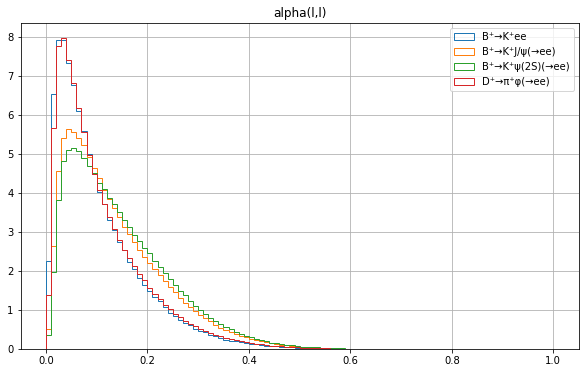

In [27]:
for idx in range(4):
    plt.hist(truthed[idx]['angle_ee_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

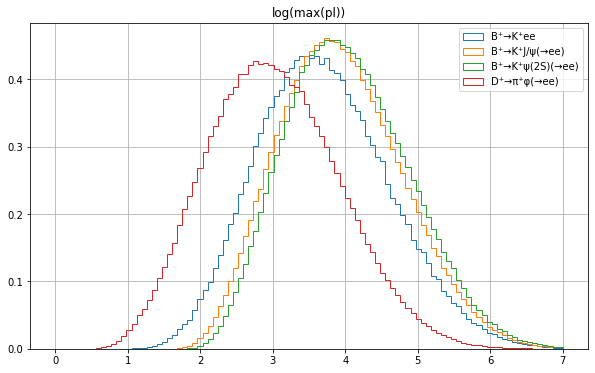

In [28]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 7, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

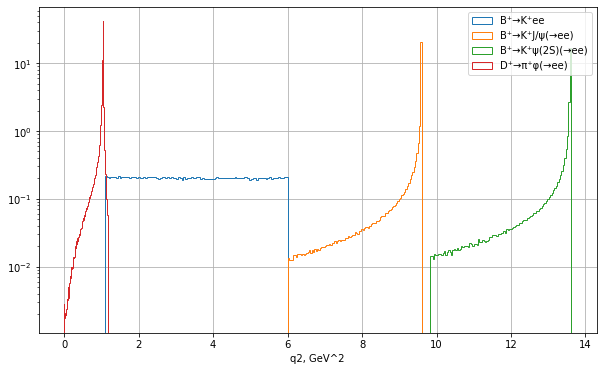

In [29]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2_TRUE'], label="%s"%df_index[idx],
             density=True, bins=100, histtype='step', log=True)
plt.xlabel(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

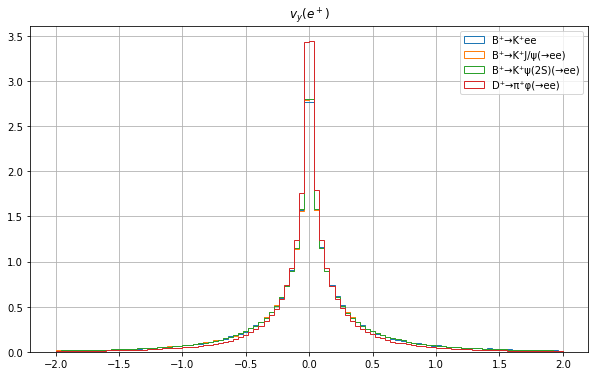

In [30]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['ep_origY_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^+)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [31]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [32]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [33]:
class ScaledDataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset
    def as_numpy(self, f):
        return lambda x: to_numpy(f(from_numpy(self.transform(x))))
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [34]:
def plot_ds(dataset, ax=None):
    axis = plt.gca() if ax is None else ax
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.inverse_transform(2*ones)[0,0:2]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [35]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [36]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [37]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [38]:
def plot_one(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = dataset.inverse_transform([[-3.0], [3.0]])
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(dataset.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [39]:
def plot_field(f, dataset, name=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.inverse_transform(3*ones)[0,0:2]
    #X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    X_test = dataset.inverse_transform(np.asarray(bridson.poisson_disc_samples(8.0, 8.0, 0.02)) - 4)
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [40]:
def plot_clf(ds, clf, c0, c1, ax=None):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]), ax=ax)

In [41]:
def plot_clf_min_max(ds, clf, ax_min=None, ax_max=None):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    plot_field(ds.as_numpy(f_min), ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None, ax=ax_min)
    plot_field(ds.as_numpy(f_max), ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None, ax=ax_max)

In [42]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = ScaledDataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=100000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=100000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [43]:
%%time
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()

INFO:root:Epoch 0, 1.391276
INFO:root:Epoch 1, 1.383584
INFO:root:Epoch 2, 1.377943
INFO:root:Epoch 3, 1.371200
INFO:root:Epoch 4, 1.368844
INFO:root:Epoch 5, 1.367970
INFO:root:Epoch 6, 1.367178
INFO:root:Epoch 7, 1.366455
INFO:root:Epoch 8, 1.365807
INFO:root:Epoch 9, 1.365304
INFO:root:Epoch 10, 1.364918
INFO:root:Epoch 11, 1.364659
INFO:root:Epoch 12, 1.364501
INFO:root:Epoch 13, 1.364409
INFO:root:Epoch 14, 1.364335
INFO:root:Epoch 15, 1.364301
INFO:root:Epoch 16, 1.364282
INFO:root:Epoch 17, 1.364274
INFO:root:Epoch 18, 1.364200
INFO:root:Epoch 19, 1.364173
INFO:root:Epoch 20, 1.364170
INFO:root:Epoch 21, 1.364133
INFO:root:Epoch 22, 1.364103
INFO:root:Epoch 23, 1.364084
INFO:root:Epoch 24, 1.364055
INFO:root:Epoch 25, 1.364033
INFO:root:Epoch 26, 1.364014
INFO:root:Epoch 27, 1.363982
INFO:root:Epoch 28, 1.363961
INFO:root:Epoch 29, 1.363923
INFO:root:Epoch 30, 1.363896
INFO:root:Epoch 31, 1.363850
INFO:root:Epoch 32, 1.363861
INFO:root:Epoch 33, 1.363807
INFO:root:Epoch 34, 1.36

CPU times: user 36.7 s, sys: 4 s, total: 40.7 s
Wall time: 40.6 s


Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [44]:
%%time
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.141351
INFO:root:Epoch 1, 1.098546
INFO:root:Epoch 2, 1.095370
INFO:root:Epoch 3, 1.092499
INFO:root:Epoch 4, 1.088721
INFO:root:Epoch 5, 1.084207
INFO:root:Epoch 6, 1.080791
INFO:root:Epoch 7, 1.079677
INFO:root:Epoch 8, 1.079171
INFO:root:Epoch 9, 1.078761
INFO:root:Epoch 10, 1.078391
INFO:root:Epoch 11, 1.078079
INFO:root:Epoch 12, 1.077825
INFO:root:Epoch 13, 1.077521
INFO:root:Epoch 14, 1.077313
INFO:root:Epoch 15, 1.077160
INFO:root:Epoch 16, 1.076978
INFO:root:Epoch 17, 1.076859
INFO:root:Epoch 18, 1.076765
INFO:root:Epoch 19, 1.076675
INFO:root:Epoch 20, 1.076612
INFO:root:Epoch 21, 1.076532
INFO:root:Epoch 22, 1.076471
INFO:root:Epoch 23, 1.076473
INFO:root:Epoch 24, 1.076394
INFO:root:Epoch 25, 1.076356
INFO:root:Epoch 26, 1.076354
INFO:root:Epoch 27, 1.076347
INFO:root:Epoch 28, 1.076296
INFO:root:Epoch 29, 1.076274
INFO:root:Epoch 30, 1.076276
INFO:root:Epoch 31, 1.076228
INFO:root:Epoch 32, 1.076204
INFO:root:Epoch 33, 1.076192
INFO:root:Epoch 34, 1.07

CPU times: user 26.1 s, sys: 1.45 s, total: 27.5 s
Wall time: 27.4 s


Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [45]:
%%time
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.386110
INFO:root:Epoch 1, 1.367259
INFO:root:Epoch 2, 1.329740
INFO:root:Epoch 3, 1.232832
INFO:root:Epoch 4, 1.096846
INFO:root:Epoch 5, 1.019674
INFO:root:Epoch 6, 0.986892
INFO:root:Epoch 7, 0.955013
INFO:root:Epoch 8, 0.925040
INFO:root:Epoch 9, 0.905761
INFO:root:Epoch 10, 0.895313
INFO:root:Epoch 11, 0.887656
INFO:root:Epoch 12, 0.881167
INFO:root:Epoch 13, 0.875526
INFO:root:Epoch 14, 0.870054
INFO:root:Epoch 15, 0.864597
INFO:root:Epoch 16, 0.859381
INFO:root:Epoch 17, 0.854649
INFO:root:Epoch 18, 0.850646
INFO:root:Epoch 19, 0.847463
INFO:root:Epoch 20, 0.844918
INFO:root:Epoch 21, 0.842962
INFO:root:Epoch 22, 0.840986
INFO:root:Epoch 23, 0.839330
INFO:root:Epoch 24, 0.837902
INFO:root:Epoch 25, 0.836395
INFO:root:Epoch 26, 0.835009
INFO:root:Epoch 27, 0.833723
INFO:root:Epoch 28, 0.832393
INFO:root:Epoch 29, 0.831198
INFO:root:Epoch 30, 0.829888
INFO:root:Epoch 31, 0.828694
INFO:root:Epoch 32, 0.827528
INFO:root:Epoch 33, 0.826376
INFO:root:Epoch 34, 0.82

CPU times: user 37.3 s, sys: 3.83 s, total: 41.1 s
Wall time: 41 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [46]:
%%time
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.109407
INFO:root:Epoch 1, 1.097853
INFO:root:Epoch 2, 1.093600
INFO:root:Epoch 3, 1.087066
INFO:root:Epoch 4, 1.073296
INFO:root:Epoch 5, 1.046319
INFO:root:Epoch 6, 1.007689
INFO:root:Epoch 7, 0.976061
INFO:root:Epoch 8, 0.959554
INFO:root:Epoch 9, 0.948100
INFO:root:Epoch 10, 0.936121
INFO:root:Epoch 11, 0.922133
INFO:root:Epoch 12, 0.905780
INFO:root:Epoch 13, 0.889187
INFO:root:Epoch 14, 0.877160
INFO:root:Epoch 15, 0.870137
INFO:root:Epoch 16, 0.864462
INFO:root:Epoch 17, 0.859154
INFO:root:Epoch 18, 0.854000
INFO:root:Epoch 19, 0.848807
INFO:root:Epoch 20, 0.843692
INFO:root:Epoch 21, 0.838783
INFO:root:Epoch 22, 0.833858
INFO:root:Epoch 23, 0.829156
INFO:root:Epoch 24, 0.824767
INFO:root:Epoch 25, 0.820832
INFO:root:Epoch 26, 0.817104
INFO:root:Epoch 27, 0.814025
INFO:root:Epoch 28, 0.811132
INFO:root:Epoch 29, 0.808718
INFO:root:Epoch 30, 0.806808
INFO:root:Epoch 31, 0.804897
INFO:root:Epoch 32, 0.803376
INFO:root:Epoch 33, 0.802064
INFO:root:Epoch 34, 0.80

CPU times: user 27.3 s, sys: 1.76 s, total: 29.1 s
Wall time: 28.9 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [47]:
%%time
e_ptpt = Estimator(["log_ep_PT", "log_em_PT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.402135
INFO:root:Epoch 1, 1.345192
INFO:root:Epoch 2, 1.251670
INFO:root:Epoch 3, 1.132726
INFO:root:Epoch 4, 1.098144
INFO:root:Epoch 5, 1.090085
INFO:root:Epoch 6, 1.084672
INFO:root:Epoch 7, 1.079973
INFO:root:Epoch 8, 1.075763
INFO:root:Epoch 9, 1.072020
INFO:root:Epoch 10, 1.068727
INFO:root:Epoch 11, 1.065924
INFO:root:Epoch 12, 1.063631
INFO:root:Epoch 13, 1.061789
INFO:root:Epoch 14, 1.060316
INFO:root:Epoch 15, 1.059104
INFO:root:Epoch 16, 1.058082
INFO:root:Epoch 17, 1.057202
INFO:root:Epoch 18, 1.056413
INFO:root:Epoch 19, 1.055766
INFO:root:Epoch 20, 1.055234
INFO:root:Epoch 21, 1.054830
INFO:root:Epoch 22, 1.054524
INFO:root:Epoch 23, 1.054176
INFO:root:Epoch 24, 1.053940
INFO:root:Epoch 25, 1.053657
INFO:root:Epoch 26, 1.053436
INFO:root:Epoch 27, 1.053157
INFO:root:Epoch 28, 1.052872
INFO:root:Epoch 29, 1.052595
INFO:root:Epoch 30, 1.052314
INFO:root:Epoch 31, 1.052006
INFO:root:Epoch 32, 1.051639
INFO:root:Epoch 33, 1.051344
INFO:root:Epoch 34, 1.05

CPU times: user 37 s, sys: 3.85 s, total: 40.9 s
Wall time: 40.7 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [48]:
%%time
e_ptpt3 = Estimator(["log_ep_PT", "log_em_PT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.102332
INFO:root:Epoch 1, 1.092771
INFO:root:Epoch 2, 1.084110
INFO:root:Epoch 3, 1.069749
INFO:root:Epoch 4, 1.052612
INFO:root:Epoch 5, 1.043958
INFO:root:Epoch 6, 1.039010
INFO:root:Epoch 7, 1.034721
INFO:root:Epoch 8, 1.030735
INFO:root:Epoch 9, 1.027046
INFO:root:Epoch 10, 1.023532
INFO:root:Epoch 11, 1.020189
INFO:root:Epoch 12, 1.016999
INFO:root:Epoch 13, 1.014061
INFO:root:Epoch 14, 1.011418
INFO:root:Epoch 15, 1.009333
INFO:root:Epoch 16, 1.007983
INFO:root:Epoch 17, 1.007289
INFO:root:Epoch 18, 1.006965
INFO:root:Epoch 19, 1.006574
INFO:root:Epoch 20, 1.006329
INFO:root:Epoch 21, 1.006128
INFO:root:Epoch 22, 1.005845
INFO:root:Epoch 23, 1.005522
INFO:root:Epoch 24, 1.005252
INFO:root:Epoch 25, 1.005016
INFO:root:Epoch 26, 1.004737
INFO:root:Epoch 27, 1.004390
INFO:root:Epoch 28, 1.004197
INFO:root:Epoch 29, 1.003799
INFO:root:Epoch 30, 1.003574
INFO:root:Epoch 31, 1.003198
INFO:root:Epoch 32, 1.002908
INFO:root:Epoch 33, 1.002746
INFO:root:Epoch 34, 1.00

CPU times: user 27.1 s, sys: 1.78 s, total: 28.9 s
Wall time: 28.8 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

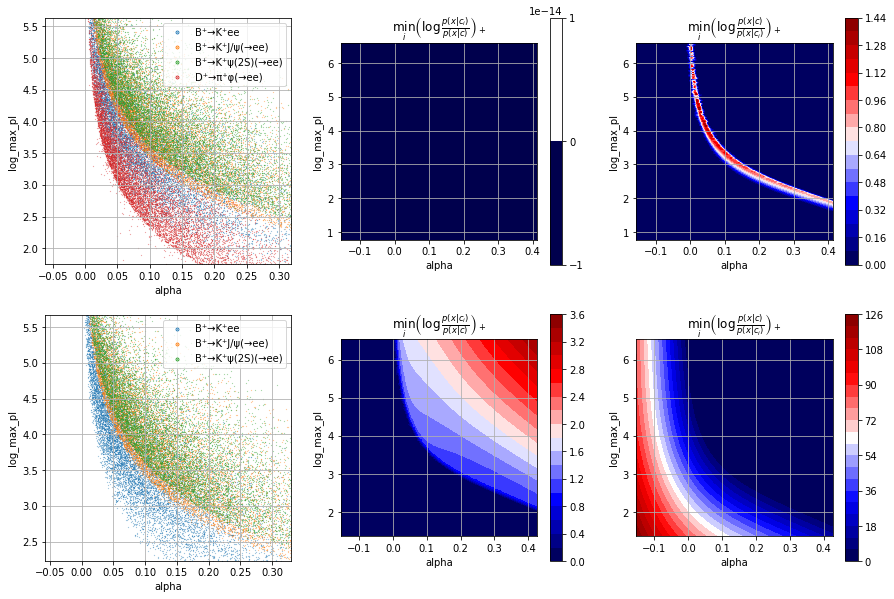

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_ds(e_la.ds, ax=ax[0,0])
plot_clf_min_max(e_la.ds, e_la.model, ax_min=ax[0,1], ax_max=ax[0,2])
plot_ds(e_la3.ds, ax=ax[1,0])
plot_clf_min_max(e_la3.ds, e_la3.model, ax_min=ax[1,1], ax_max=ax[1,2])
plt.show()

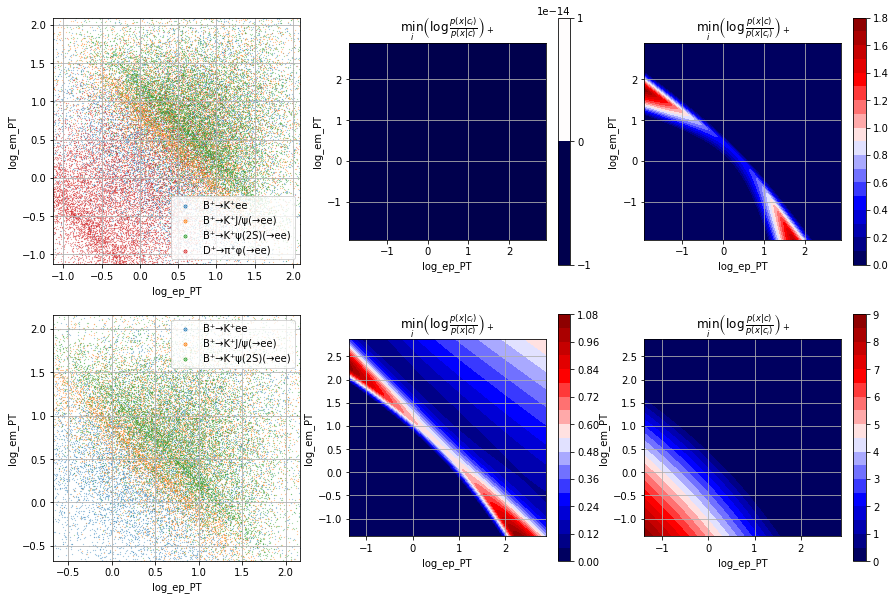

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_ds(e_ptpt.ds, ax=ax[0,0])
plot_clf_min_max(e_ptpt.ds, e_ptpt.model, ax_min=ax[0,1], ax_max=ax[0,2])
plot_ds(e_ptpt3.ds, ax=ax[1,0])
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model, ax_min=ax[1,1], ax_max=ax[1,2])
plt.show()

### Crafting a loss

In [51]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

In [52]:
def compute_lipschitz(model, loader, device=device):
    model.eval()
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        x.requires_grad = True
        model.zero_grad()
        fx = model(x)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x.grad.norm(dim=1)).item())
    return L

In [53]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [54]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [55]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [56]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [57]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    base = model[0]
    linear = model[1]
    opt = torch.optim.SGD(params=base.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                x.requires_grad = True
                clone.zero_grad()
                fx = clone(x)
                L_loss = torch.sum(fx)
                L_loss.backward()
                dx = x.grad
                L = max(L, torch.max(dx.norm(dim=1)).item())
                x.requires_grad = False

                if target_L is not None:
                    ext_dx = dx[None,...] * dx_ # 2*B*n_features
                    ext_x = x[None,...] + ext_dx

                    pred_dfx = model(ext_x) # 2*B*N
                    dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                    loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                    total_loss += loss_L
                    loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [58]:
class Weighting:
    def __init__(self, estimator, name=None, n_classes=None, selected_class=0):
        n_outs = len(list(estimator.ds.indices))
        n_classes = n_outs if n_classes is None else n_outs
        self.estimator = estimator
        self.n_outs = n_outs
        self.n_classes = n_classes
        self.name = name
        self.selected_class = selected_class
        
        self.model = torch.nn.Sequential(
            torch.nn.Sequential(
                clone_model(estimator.model),
                torch.nn.Softmax(dim=-1),
            ),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device)

    def train(self, **kwargs):
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=100000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, self.selected_class, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, self.selected_class, epochs=500, alpha=300, **kwargs)
        return self.model
    
    def w_model_np(self):
        return self.estimator.ds.as_numpy(self.model)
    
    def dataset(self):
        return self.estimator.ds

In [59]:
%%time
w_la = Weighting(e_la, name="w₄[α,p]")
w_la.train(target_L=1.0)

Epoch 0 loss=-4.000084 W+c=[ 4.7176 -4.4366  2.3249 -1.6109] det=0.006598 L=0.949412
Epoch 1 loss=-4.000083 W+c=[ 4.7154 -4.4168  2.2788 -1.6112] det=0.006664 L=0.955039
Epoch 2 loss=-4.000082 W+c=[ 4.7132 -4.3972  2.2343 -1.6115] det=0.006730 L=0.960553
Epoch 3 loss=-4.000082 W+c=[ 4.711  -4.3779  2.1913 -1.6118] det=0.006795 L=0.965953
Epoch 4 loss=-4.000082 W+c=[ 4.7088 -4.3588  2.1497 -1.6122] det=0.006859 L=0.971239
Epoch 5 loss=-4.000082 W+c=[ 4.7065 -4.3399  2.1095 -1.6125] det=0.006922 L=0.976411
Epoch 6 loss=-4.000082 W+c=[ 4.7043 -4.3213  2.0706 -1.6128] det=0.006985 L=0.981732
Epoch 7 loss=-4.000083 W+c=[ 4.702  -4.3029  2.033  -1.6131] det=0.007047 L=0.987569
Epoch 8 loss=-4.000083 W+c=[ 4.6997 -4.2847  1.9966 -1.6134] det=0.007109 L=0.993302
Epoch 9 loss=-4.000082 W+c=[ 4.6974 -4.2667  1.9614 -1.6137] det=0.007170 L=0.998932
Epoch 10 loss=-4.000081 W+c=[ 4.6952 -4.2489  1.9272 -1.614 ] det=0.007230 L=1.004458
Epoch 11 loss=-4.000083 W+c=[ 4.6929 -4.2313  1.8942 -1.6142] de

Epoch 96 loss=-4.000082 W+c=[ 4.4945 -3.153   0.7669 -1.6234] det=0.010970 L=1.491015
Epoch 97 loss=-4.000083 W+c=[ 4.4923 -3.1435  0.7618 -1.6233] det=0.011004 L=1.496212
Epoch 98 loss=-4.000082 W+c=[ 4.49   -3.1341  0.7569 -1.6233] det=0.011038 L=1.501396
Epoch 99 loss=-4.000083 W+c=[ 4.4877 -3.1248  0.752  -1.6233] det=0.011072 L=1.506564
Epoch 100 loss=-4.000082 W+c=[ 4.4855 -3.1155  0.7472 -1.6232] det=0.011105 L=1.511720
Epoch 101 loss=-4.000082 W+c=[ 4.4832 -3.1062  0.7424 -1.6232] det=0.011139 L=1.517244
Epoch 102 loss=-4.000082 W+c=[ 4.481  -3.097   0.7377 -1.6231] det=0.011172 L=1.522764
Epoch 103 loss=-4.000082 W+c=[ 4.4787 -3.0878  0.7331 -1.623 ] det=0.011205 L=1.528268
Epoch 104 loss=-4.000082 W+c=[ 4.4765 -3.0787  0.7286 -1.623 ] det=0.011239 L=1.533754
Epoch 105 loss=-4.000083 W+c=[ 4.4742 -3.0697  0.7241 -1.6229] det=0.011272 L=1.539225
Epoch 106 loss=-4.000082 W+c=[ 4.472  -3.0607  0.7197 -1.6229] det=0.011305 L=1.544679
Epoch 107 loss=-4.000083 W+c=[ 4.4697 -3.0517  

Epoch 191 loss=-4.000083 W+c=[ 4.2946 -2.4428  0.4873 -1.6124] det=0.013829 L=1.887772
Epoch 192 loss=-4.000083 W+c=[ 4.2927 -2.4369  0.4856 -1.6123] det=0.013856 L=1.890868
Epoch 193 loss=-4.000083 W+c=[ 4.2908 -2.4311  0.4839 -1.6121] det=0.013883 L=1.893957
Epoch 194 loss=-4.000083 W+c=[ 4.2889 -2.4253  0.4822 -1.612 ] det=0.013910 L=1.897039
Epoch 195 loss=-4.000084 W+c=[ 4.287  -2.4195  0.4805 -1.6118] det=0.013938 L=1.900120
Epoch 196 loss=-4.000084 W+c=[ 4.2851 -2.4138  0.4789 -1.6116] det=0.013965 L=1.903193
Epoch 197 loss=-4.000082 W+c=[ 4.2832 -2.4081  0.4773 -1.6115] det=0.013992 L=1.906261
Epoch 198 loss=-4.000083 W+c=[ 4.2813 -2.4024  0.4756 -1.6113] det=0.014019 L=1.909324
Epoch 199 loss=-4.000084 W+c=[ 4.2794 -2.3967  0.474  -1.6112] det=0.014045 L=1.912381
W= [[0.3988 0.1162 0.0547 0.2745]
 [0.1823 0.3114 0.2364 0.0279]
 [0.1943 0.5614 0.7073 0.008 ]
 [0.2246 0.011  0.0017 0.6897]]
W+= [[ 4.2775 -2.391   0.4724 -1.611 ]
 [-3.7839 10.2186 -3.1256  1.1287]
 [ 1.8433 -7.46

Epoch 83 loss=-8.106497 W+c=[17.5657 -0.5091  0.2798 -0.9749] det=0.006172 L=3.326513
Epoch 84 loss=-8.103472 W+c=[17.5734 -0.5071  0.278  -0.9746] det=0.006183 L=3.326546
Epoch 85 loss=-8.100426 W+c=[17.5811 -0.5051  0.2763 -0.9743] det=0.006194 L=3.326591
Epoch 86 loss=-8.097351 W+c=[17.5888 -0.5032  0.2745 -0.974 ] det=0.006205 L=3.326639
Epoch 87 loss=-8.094261 W+c=[17.5965 -0.5013  0.2728 -0.9737] det=0.006216 L=3.326706
Epoch 88 loss=-8.091153 W+c=[17.6043 -0.4994  0.2711 -0.9734] det=0.006226 L=3.326779
Epoch 89 loss=-8.088031 W+c=[17.6121 -0.4976  0.2695 -0.973 ] det=0.006237 L=3.326885
Epoch 90 loss=-8.084885 W+c=[17.6199 -0.4957  0.2678 -0.9727] det=0.006247 L=3.327006
Epoch 91 loss=-8.081733 W+c=[17.6277 -0.494   0.2662 -0.9723] det=0.006257 L=3.327152
Epoch 92 loss=-8.078562 W+c=[17.6355 -0.4922  0.2646 -0.972 ] det=0.006268 L=3.327307
Epoch 93 loss=-8.075373 W+c=[17.6433 -0.4905  0.2631 -0.9716] det=0.006278 L=3.327467
Epoch 94 loss=-8.072179 W+c=[17.6511 -0.4888  0.2615 -

Epoch 178 loss=-7.813482 W+c=[18.2645 -0.3991  0.1823 -0.9347] det=0.006872 L=3.352608
Epoch 179 loss=-7.810809 W+c=[18.2709 -0.3984  0.1818 -0.9343] det=0.006877 L=3.352892
Epoch 180 loss=-7.808138 W+c=[18.2772 -0.3977  0.1812 -0.9339] det=0.006882 L=3.353172
Epoch 181 loss=-7.805488 W+c=[18.2835 -0.3971  0.1806 -0.9335] det=0.006887 L=3.353451
Epoch 182 loss=-7.802845 W+c=[18.2898 -0.3964  0.18   -0.9331] det=0.006892 L=3.353726
Epoch 183 loss=-7.800215 W+c=[18.2961 -0.3957  0.1795 -0.9328] det=0.006896 L=3.354001
Epoch 184 loss=-7.797594 W+c=[18.3023 -0.395   0.1789 -0.9324] det=0.006901 L=3.354286
Epoch 185 loss=-7.794990 W+c=[18.3086 -0.3944  0.1784 -0.932 ] det=0.006906 L=3.354574
Epoch 186 loss=-7.792395 W+c=[18.3148 -0.3937  0.1778 -0.9316] det=0.006910 L=3.354859
Epoch 187 loss=-7.789809 W+c=[18.3209 -0.3931  0.1773 -0.9312] det=0.006915 L=3.355142
Epoch 188 loss=-7.787236 W+c=[18.3271 -0.3924  0.1767 -0.9308] det=0.006920 L=3.355425
Epoch 189 loss=-7.784673 W+c=[18.3332 -0.39

Epoch 273 loss=-7.606266 W+c=[18.7695 -0.3505  0.143  -0.9043] det=0.007221 L=3.373659
Epoch 274 loss=-7.604530 W+c=[18.7738 -0.3501  0.1427 -0.904 ] det=0.007224 L=3.373812
Epoch 275 loss=-7.602800 W+c=[18.7782 -0.3497  0.1425 -0.9038] det=0.007227 L=3.373962
Epoch 276 loss=-7.601079 W+c=[18.7825 -0.3494  0.1422 -0.9035] det=0.007230 L=3.374111
Epoch 277 loss=-7.599368 W+c=[18.7868 -0.349   0.1419 -0.9033] det=0.007232 L=3.374259
Epoch 278 loss=-7.597661 W+c=[18.7911 -0.3486  0.1416 -0.903 ] det=0.007235 L=3.374405
Epoch 279 loss=-7.595962 W+c=[18.7953 -0.3483  0.1413 -0.9028] det=0.007238 L=3.374550
Epoch 280 loss=-7.594272 W+c=[18.7996 -0.3479  0.141  -0.9025] det=0.007240 L=3.374692
Epoch 281 loss=-7.592587 W+c=[18.8038 -0.3475  0.1408 -0.9023] det=0.007243 L=3.374835
Epoch 282 loss=-7.590918 W+c=[18.808  -0.3472  0.1405 -0.902 ] det=0.007246 L=3.374978
Epoch 283 loss=-7.589251 W+c=[18.8122 -0.3468  0.1402 -0.9018] det=0.007249 L=3.375118
Epoch 284 loss=-7.587591 W+c=[18.8164 -0.34

Epoch 368 loss=-7.471665 W+c=[19.1126 -0.3219  0.1215 -0.8847] det=0.007437 L=3.383946
Epoch 369 loss=-7.470529 W+c=[19.1156 -0.3216  0.1214 -0.8846] det=0.007439 L=3.384016
Epoch 370 loss=-7.469398 W+c=[19.1185 -0.3214  0.1212 -0.8844] det=0.007441 L=3.384083
Epoch 371 loss=-7.468265 W+c=[19.1214 -0.3212  0.121  -0.8842] det=0.007442 L=3.384150
Epoch 372 loss=-7.467144 W+c=[19.1243 -0.3209  0.1209 -0.8841] det=0.007444 L=3.384212
Epoch 373 loss=-7.466028 W+c=[19.1273 -0.3207  0.1207 -0.8839] det=0.007446 L=3.384278
Epoch 374 loss=-7.464913 W+c=[19.1301 -0.3205  0.1205 -0.8838] det=0.007448 L=3.384340
Epoch 375 loss=-7.463804 W+c=[19.133  -0.3202  0.1203 -0.8836] det=0.007450 L=3.384406
Epoch 376 loss=-7.462701 W+c=[19.1359 -0.32    0.1202 -0.8834] det=0.007451 L=3.384471
Epoch 377 loss=-7.461606 W+c=[19.1387 -0.3198  0.12   -0.8833] det=0.007453 L=3.384538
Epoch 378 loss=-7.460509 W+c=[19.1416 -0.3195  0.1198 -0.8831] det=0.007455 L=3.384604
Epoch 379 loss=-7.459419 W+c=[19.1444 -0.31

Epoch 463 loss=-7.382687 W+c=[19.3443 -0.303   0.1081 -0.8716] det=0.007589 L=3.387561
Epoch 464 loss=-7.381935 W+c=[19.3463 -0.3029  0.108  -0.8715] det=0.007590 L=3.387572
Epoch 465 loss=-7.381176 W+c=[19.3482 -0.3027  0.1078 -0.8714] det=0.007592 L=3.387581
Epoch 466 loss=-7.380421 W+c=[19.3502 -0.3025  0.1077 -0.8713] det=0.007593 L=3.387590
Epoch 467 loss=-7.379675 W+c=[19.3522 -0.3024  0.1076 -0.8712] det=0.007594 L=3.387596
Epoch 468 loss=-7.378930 W+c=[19.3541 -0.3022  0.1075 -0.871 ] det=0.007596 L=3.387604
Epoch 469 loss=-7.378183 W+c=[19.356  -0.302   0.1074 -0.8709] det=0.007597 L=3.387609
Epoch 470 loss=-7.377446 W+c=[19.358  -0.3019  0.1073 -0.8708] det=0.007598 L=3.387617
Epoch 471 loss=-7.376707 W+c=[19.3599 -0.3017  0.1072 -0.8707] det=0.007600 L=3.387626
Epoch 472 loss=-7.375969 W+c=[19.3618 -0.3016  0.1071 -0.8706] det=0.007601 L=3.387635
Epoch 473 loss=-7.375238 W+c=[19.3637 -0.3014  0.1069 -0.8705] det=0.007602 L=3.387644
Epoch 474 loss=-7.374515 W+c=[19.3656 -0.30

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [60]:
%%time
w_la3 = Weighting(e_la3, name="w₃[α,p]")
w_la3.train(target_L=1.0)

Epoch 0 loss=-3.000078 W+c=[ 1.8994 -2.102   1.209 ] det=0.022970 L=0.812540
Epoch 1 loss=-3.000078 W+c=[ 1.8996 -2.0973  1.2033] det=0.023026 L=0.815011
Epoch 2 loss=-3.000077 W+c=[ 1.8998 -2.0926  1.1976] det=0.023082 L=0.817480
Epoch 3 loss=-3.000078 W+c=[ 1.9001 -2.0879  1.192 ] det=0.023138 L=0.819947
Epoch 4 loss=-3.000078 W+c=[ 1.9003 -2.0833  1.1864] det=0.023193 L=0.822413
Epoch 5 loss=-3.000077 W+c=[ 1.9006 -2.0787  1.1809] det=0.023249 L=0.824877
Epoch 6 loss=-3.000080 W+c=[ 1.9008 -2.0741  1.1754] det=0.023304 L=0.827339
Epoch 7 loss=-3.000080 W+c=[ 1.901  -2.0695  1.1699] det=0.023360 L=0.829801
Epoch 8 loss=-3.000077 W+c=[ 1.9013 -2.0649  1.1645] det=0.023415 L=0.832260
Epoch 9 loss=-3.000079 W+c=[ 1.9015 -2.0604  1.1592] det=0.023471 L=0.834718
Epoch 10 loss=-3.000080 W+c=[ 1.9017 -2.0559  1.1538] det=0.023526 L=0.837175
Epoch 11 loss=-3.000078 W+c=[ 1.902  -2.0514  1.1486] det=0.023581 L=0.839631
Epoch 12 loss=-3.000079 W+c=[ 1.9022 -2.047   1.1433] det=0.023636 L=0.842

Epoch 106 loss=-3.000077 W+c=[ 1.9187 -1.7039  0.7877] det=0.028539 L=1.070363
Epoch 107 loss=-3.000078 W+c=[ 1.9188 -1.7009  0.785 ] det=0.028588 L=1.072791
Epoch 108 loss=-3.000077 W+c=[ 1.9189 -1.6979  0.7823] det=0.028638 L=1.075219
Epoch 109 loss=-3.000078 W+c=[ 1.9191 -1.6949  0.7796] det=0.028687 L=1.077647
Epoch 110 loss=-3.000077 W+c=[ 1.9192 -1.6919  0.777 ] det=0.028736 L=1.080076
Epoch 111 loss=-3.000077 W+c=[ 1.9193 -1.689   0.7743] det=0.028786 L=1.082505
Epoch 112 loss=-3.000077 W+c=[ 1.9195 -1.686   0.7717] det=0.028835 L=1.084934
Epoch 113 loss=-3.000077 W+c=[ 1.9196 -1.6831  0.7691] det=0.028884 L=1.087363
Epoch 114 loss=-3.000078 W+c=[ 1.9197 -1.6802  0.7665] det=0.028933 L=1.089792
Epoch 115 loss=-3.000077 W+c=[ 1.9199 -1.6772  0.7639] det=0.028982 L=1.092222
Epoch 116 loss=-3.000077 W+c=[ 1.92   -1.6743  0.7614] det=0.029031 L=1.094652
Epoch 117 loss=-3.000078 W+c=[ 1.9201 -1.6714  0.7588] det=0.029080 L=1.097082
Epoch 118 loss=-3.000077 W+c=[ 1.9202 -1.6685  0.756

Epoch 8 loss=-11.573963 W+c=[ 2.3222 -0.5109  0.2639] det=0.030516 L=2.844911
Epoch 9 loss=-10.990081 W+c=[ 2.3546 -0.4777  0.2526] det=0.030080 L=3.018963
Epoch 10 loss=-10.460066 W+c=[ 2.3852 -0.4491  0.2428] det=0.029668 L=3.203197
Epoch 11 loss=-9.968083 W+c=[ 2.414  -0.424   0.2341] det=0.029279 L=3.377532
Epoch 12 loss=-9.501744 W+c=[ 2.4415 -0.402   0.2263] det=0.028910 L=3.536306
Epoch 13 loss=-9.051147 W+c=[ 2.4679 -0.3823  0.2192] det=0.028560 L=3.718378
Epoch 14 loss=-8.608120 W+c=[ 2.4932 -0.3647  0.2128] det=0.028226 L=3.900991
Epoch 15 loss=-8.165830 W+c=[ 2.5178 -0.3488  0.2068] det=0.027905 L=4.083519
Epoch 16 loss=-7.718478 W+c=[ 2.5417 -0.3344  0.2013] det=0.027595 L=4.256148
Epoch 17 loss=-7.261087 W+c=[ 2.5652 -0.3213  0.1961] det=0.027294 L=4.420873
Epoch 18 loss=-6.789339 W+c=[ 2.5885 -0.3093  0.1913] det=0.027000 L=4.593206
Epoch 19 loss=-6.299552 W+c=[ 2.6116 -0.2983  0.1866] det=0.026711 L=4.761961
Epoch 20 loss=-5.788601 W+c=[ 2.6348 -0.2882  0.1822] det=0.026

Epoch 114 loss=-0.883835 W+c=[ 5.8166 -0.1537  0.0467] det=0.011746 L=5.817369
Epoch 115 loss=-0.912433 W+c=[ 5.8317 -0.1534  0.0462] det=0.011745 L=5.802833
Epoch 116 loss=-0.940427 W+c=[ 5.8465 -0.153   0.0458] det=0.011745 L=5.796372
Epoch 117 loss=-0.967835 W+c=[ 5.8609 -0.1527  0.0454] det=0.011746 L=5.790406
Epoch 118 loss=-0.994681 W+c=[ 5.8751 -0.1523  0.045 ] det=0.011747 L=5.783752
Epoch 119 loss=-1.020975 W+c=[ 5.889  -0.1519  0.0446] det=0.011749 L=5.776464
Epoch 120 loss=-1.046748 W+c=[ 5.9027 -0.1516  0.0442] det=0.011752 L=5.768585
Epoch 121 loss=-1.072006 W+c=[ 5.916  -0.1512  0.0438] det=0.011756 L=5.760160
Epoch 122 loss=-1.096776 W+c=[ 5.9291 -0.1509  0.0434] det=0.011760 L=5.751231
Epoch 123 loss=-1.121062 W+c=[ 5.9419 -0.1505  0.043 ] det=0.011764 L=5.741837
Epoch 124 loss=-1.144890 W+c=[ 5.9545 -0.1502  0.0427] det=0.011769 L=5.732015
Epoch 125 loss=-1.168272 W+c=[ 5.9668 -0.1498  0.0423] det=0.011775 L=5.721799
Epoch 126 loss=-1.191211 W+c=[ 5.9789 -0.1495  0.041

Epoch 218 loss=-2.344551 W+c=[ 6.4197 -0.1234  0.0231] det=0.013595 L=5.154853
Epoch 219 loss=-2.351555 W+c=[ 6.4199 -0.1232  0.023 ] det=0.013623 L=5.151313
Epoch 220 loss=-2.358495 W+c=[ 6.4201 -0.1229  0.0229] det=0.013650 L=5.147785
Epoch 221 loss=-2.365368 W+c=[ 6.4202 -0.1227  0.0228] det=0.013677 L=5.144272
Epoch 222 loss=-2.372180 W+c=[ 6.4202 -0.1225  0.0227] det=0.013705 L=5.140772
Epoch 223 loss=-2.378932 W+c=[ 6.4202 -0.1223  0.0226] det=0.013732 L=5.137288
Epoch 224 loss=-2.385623 W+c=[ 6.4202 -0.122   0.0225] det=0.013760 L=5.133818
Epoch 225 loss=-2.392254 W+c=[ 6.42   -0.1218  0.0224] det=0.013787 L=5.130364
Epoch 226 loss=-2.398821 W+c=[ 6.4199 -0.1216  0.0223] det=0.013815 L=5.126926
Epoch 227 loss=-2.405331 W+c=[ 6.4196 -0.1214  0.0223] det=0.013843 L=5.123505
Epoch 228 loss=-2.411785 W+c=[ 6.4193 -0.1212  0.0222] det=0.013871 L=5.120099
Epoch 229 loss=-2.418180 W+c=[ 6.419  -0.1209  0.0221] det=0.013899 L=5.116712
Epoch 230 loss=-2.424524 W+c=[ 6.4186 -0.1207  0.022

Epoch 322 loss=-2.842797 W+c=[ 6.2517 -0.1043  0.0184] det=0.016716 L=4.874741
Epoch 323 loss=-2.846108 W+c=[ 6.2492 -0.1041  0.0184] det=0.016747 L=4.873334
Epoch 324 loss=-2.849400 W+c=[ 6.2466 -0.104   0.0184] det=0.016779 L=4.871936
Epoch 325 loss=-2.852675 W+c=[ 6.244  -0.1038  0.0184] det=0.016810 L=4.870549
Epoch 326 loss=-2.855932 W+c=[ 6.2414 -0.1037  0.0184] det=0.016841 L=4.869171
Epoch 327 loss=-2.859172 W+c=[ 6.2389 -0.1035  0.0184] det=0.016873 L=4.867800
Epoch 328 loss=-2.862390 W+c=[ 6.2363 -0.1034  0.0184] det=0.016904 L=4.866437
Epoch 329 loss=-2.865599 W+c=[ 6.2337 -0.1032  0.0184] det=0.016935 L=4.865083
Epoch 330 loss=-2.868783 W+c=[ 6.2311 -0.1031  0.0184] det=0.016967 L=4.863737
Epoch 331 loss=-2.871953 W+c=[ 6.2285 -0.103   0.0184] det=0.016998 L=4.862397
Epoch 332 loss=-2.875107 W+c=[ 6.2259 -0.1028  0.0184] det=0.017030 L=4.861064
Epoch 333 loss=-2.878243 W+c=[ 6.2233 -0.1027  0.0184] det=0.017061 L=4.859739
Epoch 334 loss=-2.881357 W+c=[ 6.2207 -0.1025  0.018

Epoch 426 loss=-3.112126 W+c=[ 5.985  -0.0916  0.0187] det=0.019905 L=4.741116
Epoch 427 loss=-3.114145 W+c=[ 5.9826 -0.0915  0.0187] det=0.019934 L=4.739716
Epoch 428 loss=-3.116159 W+c=[ 5.9802 -0.0914  0.0187] det=0.019964 L=4.738311
Epoch 429 loss=-3.118160 W+c=[ 5.9778 -0.0913  0.0187] det=0.019993 L=4.736902
Epoch 430 loss=-3.120151 W+c=[ 5.9755 -0.0912  0.0187] det=0.020022 L=4.735489
Epoch 431 loss=-3.122143 W+c=[ 5.9731 -0.0911  0.0187] det=0.020051 L=4.734071
Epoch 432 loss=-3.124120 W+c=[ 5.9708 -0.091   0.0188] det=0.020080 L=4.732648
Epoch 433 loss=-3.126092 W+c=[ 5.9684 -0.0909  0.0188] det=0.020109 L=4.731223
Epoch 434 loss=-3.128055 W+c=[ 5.9661 -0.0908  0.0188] det=0.020138 L=4.729790
Epoch 435 loss=-3.130006 W+c=[ 5.9637 -0.0907  0.0188] det=0.020167 L=4.728354
Epoch 436 loss=-3.131949 W+c=[ 5.9614 -0.0907  0.0188] det=0.020196 L=4.726913
Epoch 437 loss=-3.133887 W+c=[ 5.9591 -0.0906  0.0188] det=0.020225 L=4.725469
Epoch 438 loss=-3.135816 W+c=[ 5.9568 -0.0905  0.018

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

In [61]:
%%time
w_ptpt = Weighting(e_ptpt, name="w₄[pt,pt]")
w_ptpt.train()

Epoch 0 loss=-4.000040 W+c=[ 15.1497 -11.1098   0.2857  -3.4011] det=0.001042 L=0.064716
Epoch 1 loss=-4.000040 W+c=[ 14.9645 -11.0116   0.3158  -3.4495] det=0.001054 L=0.064604
Epoch 2 loss=-4.000039 W+c=[ 14.7891 -10.9168   0.3434  -3.4973] det=0.001065 L=0.064501
Epoch 3 loss=-4.000040 W+c=[ 14.623  -10.8253   0.3688  -3.5446] det=0.001076 L=0.064407
Epoch 4 loss=-4.000041 W+c=[ 14.4656 -10.7371   0.392   -3.5913] det=0.001086 L=0.064321
Epoch 5 loss=-4.000041 W+c=[ 14.3167 -10.6519   0.4133  -3.6373] det=0.001096 L=0.064242
Epoch 6 loss=-4.000042 W+c=[ 14.1757 -10.5698   0.4327  -3.6826] det=0.001106 L=0.064170
Epoch 7 loss=-4.000044 W+c=[ 14.0423 -10.4905   0.4504  -3.7271] det=0.001115 L=0.064105
Epoch 8 loss=-4.000041 W+c=[ 13.9159 -10.414    0.4664  -3.7708] det=0.001125 L=0.064047
Epoch 9 loss=-4.000043 W+c=[ 13.7964 -10.3402   0.4809  -3.8136] det=0.001133 L=0.063995
Epoch 10 loss=-4.000043 W+c=[ 13.6833 -10.269    0.494   -3.8555] det=0.001142 L=0.063950
Epoch 11 loss=-4.000

Epoch 95 loss=-4.000053 W+c=[11.5256 -7.9443  0.368  -4.8313] det=0.001597 L=0.067841
Epoch 96 loss=-4.000054 W+c=[11.5198 -7.9317  0.366  -4.8309] det=0.001601 L=0.067915
Epoch 97 loss=-4.000054 W+c=[11.5141 -7.9192  0.364  -4.8306] det=0.001606 L=0.067988
Epoch 98 loss=-4.000054 W+c=[11.5083 -7.9068  0.362  -4.8301] det=0.001611 L=0.068062
Epoch 99 loss=-4.000056 W+c=[11.5026 -7.8945  0.3601 -4.8297] det=0.001615 L=0.068136
Epoch 100 loss=-4.000055 W+c=[11.4969 -7.8823  0.3582 -4.8292] det=0.001620 L=0.068211
Epoch 101 loss=-4.000056 W+c=[11.4912 -7.8701  0.3564 -4.8286] det=0.001624 L=0.068285
Epoch 102 loss=-4.000055 W+c=[11.4856 -7.8581  0.3546 -4.8281] det=0.001629 L=0.068360
Epoch 103 loss=-4.000056 W+c=[11.4799 -7.8462  0.3529 -4.8275] det=0.001634 L=0.068434
Epoch 104 loss=-4.000055 W+c=[11.4743 -7.8343  0.3512 -4.8268] det=0.001638 L=0.068509
Epoch 105 loss=-4.000054 W+c=[11.4686 -7.8226  0.3495 -4.8261] det=0.001643 L=0.068585
Epoch 106 loss=-4.000056 W+c=[11.463  -7.8109  0

Epoch 190 loss=-4.000059 W+c=[10.9883 -7.0396  0.3033 -4.7208] det=0.002026 L=0.075502
Epoch 191 loss=-4.000060 W+c=[10.9826 -7.0321  0.3034 -4.7193] det=0.002030 L=0.075589
Epoch 192 loss=-4.000059 W+c=[10.977  -7.0247  0.3035 -4.7178] det=0.002035 L=0.075677
Epoch 193 loss=-4.000059 W+c=[10.9713 -7.0173  0.3036 -4.7163] det=0.002039 L=0.075765
Epoch 194 loss=-4.000060 W+c=[10.9657 -7.0099  0.3038 -4.7148] det=0.002044 L=0.075853
Epoch 195 loss=-4.000060 W+c=[10.9601 -7.0026  0.3039 -4.7133] det=0.002048 L=0.075941
Epoch 196 loss=-4.000060 W+c=[10.9544 -6.9952  0.304  -4.7119] det=0.002053 L=0.076029
Epoch 197 loss=-4.000060 W+c=[10.9488 -6.9879  0.3042 -4.7103] det=0.002057 L=0.076118
Epoch 198 loss=-4.000061 W+c=[10.9432 -6.9807  0.3043 -4.7089] det=0.002062 L=0.076207
Epoch 199 loss=-4.000060 W+c=[10.9375 -6.9734  0.3045 -4.7073] det=0.002066 L=0.076295
W= [[0.3202 0.2386 0.2052 0.2982]
 [0.2665 0.3472 0.3135 0.0968]
 [0.2596 0.3511 0.4401 0.0521]
 [0.1537 0.0631 0.0412 0.5528]]
W+

Epoch 81 loss=-15.100434 W+c=[17.6352 -2.8085  0.9938 -2.7532] det=0.002078 L=0.252741
Epoch 82 loss=-14.869295 W+c=[17.6205 -2.7968  1.0073 -2.7469] det=0.002081 L=0.254825
Epoch 83 loss=-14.856898 W+c=[17.6341 -2.7855  1.0126 -2.7402] det=0.002082 L=0.256738
Epoch 84 loss=-14.848273 W+c=[17.6416 -2.7741  1.0183 -2.7339] det=0.002083 L=0.258658
Epoch 85 loss=-14.842362 W+c=[17.6449 -2.7628  1.0244 -2.7281] det=0.002085 L=0.260582
Epoch 86 loss=-14.838475 W+c=[17.6449 -2.7517  1.0308 -2.7225] det=0.002088 L=0.262510
Epoch 87 loss=-14.836124 W+c=[17.6424 -2.7406  1.0373 -2.717 ] det=0.002090 L=0.264439
Epoch 88 loss=-14.834999 W+c=[17.638  -2.7298  1.0439 -2.7116] det=0.002093 L=0.266369
Epoch 89 loss=-14.834858 W+c=[17.6319 -2.7192  1.0506 -2.7063] det=0.002096 L=0.268300
Epoch 90 loss=-14.835550 W+c=[17.6245 -2.7088  1.0575 -2.7011] det=0.002099 L=0.270231
Epoch 91 loss=-14.836920 W+c=[17.616  -2.6985  1.0643 -2.6959] det=0.002102 L=0.272163
Epoch 92 loss=-14.838894 W+c=[17.6065 -2.68

Epoch 175 loss=-15.443102 W+c=[16.215  -2.1781  1.4083 -2.3592] det=0.002523 L=0.437534
Epoch 176 loss=-15.451122 W+c=[16.1986 -2.1741  1.4094 -2.3562] det=0.002529 L=0.439546
Epoch 177 loss=-15.459125 W+c=[16.1823 -2.1702  1.4104 -2.3532] det=0.002536 L=0.441560
Epoch 178 loss=-15.467133 W+c=[16.166  -2.1663  1.4114 -2.3502] det=0.002542 L=0.443574
Epoch 179 loss=-15.475101 W+c=[16.1497 -2.1624  1.4123 -2.3473] det=0.002548 L=0.445590
Epoch 180 loss=-15.483082 W+c=[16.1335 -2.1585  1.4132 -2.3443] det=0.002554 L=0.447606
Epoch 181 loss=-15.491042 W+c=[16.1173 -2.1547  1.414  -2.3414] det=0.002560 L=0.449623
Epoch 182 loss=-15.498988 W+c=[16.1012 -2.1509  1.4147 -2.3385] det=0.002567 L=0.451642
Epoch 183 loss=-15.506932 W+c=[16.0852 -2.1472  1.4154 -2.3356] det=0.002573 L=0.453661
Epoch 184 loss=-15.514854 W+c=[16.0692 -2.1435  1.4161 -2.3327] det=0.002579 L=0.455681
Epoch 185 loss=-15.522762 W+c=[16.0532 -2.1398  1.4167 -2.3298] det=0.002586 L=0.457702
Epoch 186 loss=-15.530662 W+c=[1

Epoch 269 loss=-16.124283 W+c=[14.903  -1.9048  1.3432 -2.1364] det=0.003176 L=0.630535
Epoch 270 loss=-16.130604 W+c=[14.8915 -1.9027  1.3414 -2.1346] det=0.003183 L=0.632623
Epoch 271 loss=-16.136904 W+c=[14.88   -1.9006  1.3396 -2.1327] det=0.003191 L=0.634711
Epoch 272 loss=-16.143183 W+c=[14.8685 -1.8985  1.3377 -2.1309] det=0.003198 L=0.636800
Epoch 273 loss=-16.149446 W+c=[14.8571 -1.8964  1.3358 -2.1291] det=0.003206 L=0.638890
Epoch 274 loss=-16.155689 W+c=[14.8457 -1.8943  1.334  -2.1273] det=0.003214 L=0.640980
Epoch 275 loss=-16.161917 W+c=[14.8344 -1.8922  1.3321 -2.1255] det=0.003221 L=0.643071
Epoch 276 loss=-16.168125 W+c=[14.8231 -1.8902  1.3302 -2.1237] det=0.003229 L=0.645162
Epoch 277 loss=-16.174295 W+c=[14.8119 -1.8881  1.3283 -2.1219] det=0.003236 L=0.647253
Epoch 278 loss=-16.180462 W+c=[14.8007 -1.8861  1.3263 -2.1201] det=0.003244 L=0.649345
Epoch 279 loss=-16.186607 W+c=[14.7896 -1.8841  1.3244 -2.1184] det=0.003252 L=0.651437
Epoch 280 loss=-16.192732 W+c=[1

Epoch 363 loss=-16.635439 W+c=[13.997  -1.7452  1.1436 -1.9947] det=0.003917 L=0.827992
Epoch 364 loss=-16.640045 W+c=[13.9891 -1.7439  1.1414 -1.9935] det=0.003925 L=0.830092
Epoch 365 loss=-16.644636 W+c=[13.9812 -1.7425  1.1392 -1.9923] det=0.003933 L=0.832191
Epoch 366 loss=-16.649210 W+c=[13.9733 -1.7412  1.137  -1.9911] det=0.003941 L=0.834290
Epoch 367 loss=-16.653780 W+c=[13.9654 -1.7398  1.1348 -1.9899] det=0.003949 L=0.836387
Epoch 368 loss=-16.658327 W+c=[13.9576 -1.7385  1.1326 -1.9887] det=0.003957 L=0.838485
Epoch 369 loss=-16.662857 W+c=[13.9498 -1.7372  1.1305 -1.9875] det=0.003965 L=0.840582
Epoch 370 loss=-16.667372 W+c=[13.942  -1.7359  1.1283 -1.9863] det=0.003973 L=0.842678
Epoch 371 loss=-16.671879 W+c=[13.9343 -1.7345  1.1261 -1.9851] det=0.003981 L=0.844774
Epoch 372 loss=-16.676363 W+c=[13.9266 -1.7332  1.1239 -1.9839] det=0.003989 L=0.846870
Epoch 373 loss=-16.680836 W+c=[13.9189 -1.7319  1.1217 -1.9827] det=0.003997 L=0.848966
Epoch 374 loss=-16.685299 W+c=[1

Epoch 457 loss=-17.200367 W+c=[13.3587 -1.6409  0.9848 -1.8922] det=0.004610 L=1.024128
Epoch 458 loss=-17.204140 W+c=[13.3525 -1.64    0.9841 -1.8912] det=0.004616 L=1.026229
Epoch 459 loss=-17.207882 W+c=[13.3463 -1.639   0.9833 -1.8902] det=0.004622 L=1.028328
Epoch 460 loss=-17.211578 W+c=[13.3401 -1.6381  0.9825 -1.8893] det=0.004628 L=1.030429
Epoch 461 loss=-17.215263 W+c=[13.334  -1.6371  0.9818 -1.8883] det=0.004634 L=1.032525
Epoch 462 loss=-17.218889 W+c=[13.328  -1.6362  0.981  -1.8874] det=0.004640 L=1.034623
Epoch 463 loss=-17.222515 W+c=[13.322  -1.6353  0.9801 -1.8864] det=0.004646 L=1.036718
Epoch 464 loss=-17.226095 W+c=[13.316  -1.6343  0.9793 -1.8855] det=0.004652 L=1.038813
Epoch 465 loss=-17.229662 W+c=[13.31   -1.6334  0.9785 -1.8845] det=0.004658 L=1.040905
Epoch 466 loss=-17.233200 W+c=[13.3041 -1.6325  0.9777 -1.8836] det=0.004664 L=1.042997
Epoch 467 loss=-17.236702 W+c=[13.2982 -1.6315  0.9768 -1.8827] det=0.004670 L=1.045087
Epoch 468 loss=-17.240196 W+c=[1

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [62]:
%%time
w_ptpt3 = Weighting(e_ptpt3, name="w₃[pt,pt]")
w_ptpt3.train()

Epoch 0 loss=-3.000043 W+c=[ 5.2497 -5.9312  1.6627] det=0.004762 L=0.052811
Epoch 1 loss=-3.000045 W+c=[ 5.2549 -5.8904  1.6385] det=0.004800 L=0.052781
Epoch 2 loss=-3.000046 W+c=[ 5.26   -5.8512  1.6152] det=0.004837 L=0.052752
Epoch 3 loss=-3.000045 W+c=[ 5.2649 -5.8135  1.5928] det=0.004873 L=0.052723
Epoch 4 loss=-3.000044 W+c=[ 5.2697 -5.7773  1.5713] det=0.004908 L=0.052694
Epoch 5 loss=-3.000045 W+c=[ 5.2743 -5.7424  1.5506] det=0.004942 L=0.052665
Epoch 6 loss=-3.000048 W+c=[ 5.2788 -5.7088  1.5307] det=0.004976 L=0.052637
Epoch 7 loss=-3.000047 W+c=[ 5.2831 -5.6765  1.5115] det=0.005009 L=0.052611
Epoch 8 loss=-3.000044 W+c=[ 5.2873 -5.6453  1.493 ] det=0.005041 L=0.052584
Epoch 9 loss=-3.000048 W+c=[ 5.2914 -5.6152  1.4752] det=0.005073 L=0.052559
Epoch 10 loss=-3.000049 W+c=[ 5.2953 -5.5861  1.458 ] det=0.005103 L=0.052533
Epoch 11 loss=-3.000049 W+c=[ 5.2991 -5.5581  1.4414] det=0.005134 L=0.052509
Epoch 12 loss=-3.000048 W+c=[ 5.3028 -5.531   1.4255] det=0.005163 L=0.052

Epoch 106 loss=-3.000057 W+c=[ 5.2703 -4.5946  0.9908] det=0.006751 L=0.052738
Epoch 107 loss=-3.000057 W+c=[ 5.2682 -4.5907  0.9903] det=0.006762 L=0.052759
Epoch 108 loss=-3.000056 W+c=[ 5.2661 -4.5869  0.9898] det=0.006774 L=0.052781
Epoch 109 loss=-3.000058 W+c=[ 5.264  -4.5831  0.9893] det=0.006786 L=0.052803
Epoch 110 loss=-3.000056 W+c=[ 5.2619 -4.5794  0.9888] det=0.006797 L=0.052825
Epoch 111 loss=-3.000057 W+c=[ 5.2598 -4.5756  0.9884] det=0.006809 L=0.052847
Epoch 112 loss=-3.000057 W+c=[ 5.2577 -4.572   0.9879] det=0.006820 L=0.052870
Epoch 113 loss=-3.000058 W+c=[ 5.2556 -4.5683  0.9875] det=0.006832 L=0.052893
Epoch 114 loss=-3.000057 W+c=[ 5.2535 -4.5647  0.9871] det=0.006843 L=0.052917
Epoch 115 loss=-3.000057 W+c=[ 5.2514 -4.5611  0.9867] det=0.006855 L=0.052941
Epoch 116 loss=-3.000057 W+c=[ 5.2492 -4.5576  0.9864] det=0.006866 L=0.052965
Epoch 117 loss=-3.000057 W+c=[ 5.2471 -4.5541  0.986 ] det=0.006877 L=0.052989
Epoch 118 loss=-3.000057 W+c=[ 5.245  -4.5506  0.985

Epoch 7 loss=-23.733501 W+c=[ 4.4298 -3.9597  1.9432] det=0.008551 L=0.071560
Epoch 8 loss=-19.335060 W+c=[ 5.2039 -3.1369  1.1117] det=0.008578 L=0.073651
Epoch 9 loss=-16.887182 W+c=[ 5.9542 -2.7657  0.6184] det=0.008199 L=0.074493
Epoch 10 loss=-15.288605 W+c=[ 6.583  -2.578   0.3064] det=0.007800 L=0.074933
Epoch 11 loss=-14.294885 W+c=[ 7.071  -2.4695  0.1008] det=0.007486 L=0.075408
Epoch 12 loss=-28.646929 W+c=[ 7.4281 -2.3985 -0.0343] det=0.007265 L=0.076022
Epoch 13 loss=-20.292082 W+c=[ 4.8799 -3.0127  1.4754] det=0.008955 L=0.082966
Epoch 14 loss=-17.452244 W+c=[ 5.61   -2.5872  0.9316] det=0.008599 L=0.084924
Epoch 15 loss=-15.578732 W+c=[ 6.259  -2.3727  0.5887] det=0.008151 L=0.086051
Epoch 16 loss=-14.399366 W+c=[ 6.7902 -2.2517  0.3597] det=0.007771 L=0.086896
Epoch 17 loss=-13.637402 W+c=[ 7.1986 -2.1757  0.2049] det=0.007487 L=0.087701
Epoch 18 loss=-13.131608 W+c=[ 7.4997 -2.1228  0.1008] det=0.007287 L=0.088583
Epoch 19 loss=-12.786238 W+c=[ 7.716  -2.0825  0.0315] 

Epoch 111 loss=-9.563527 W+c=[ 8.4424 -1.0571  0.2937] det=0.007027 L=0.242640
Epoch 112 loss=-9.548384 W+c=[ 8.4435 -1.0526  0.2961] det=0.007029 L=0.244457
Epoch 113 loss=-9.533394 W+c=[ 8.4446 -1.0481  0.2985] det=0.007032 L=0.246277
Epoch 114 loss=-9.518565 W+c=[ 8.4457 -1.0437  0.3009] det=0.007034 L=0.248100
Epoch 115 loss=-9.503894 W+c=[ 8.4467 -1.0393  0.3033] det=0.007036 L=0.249926
Epoch 116 loss=-9.489384 W+c=[ 8.4478 -1.035   0.3056] det=0.007039 L=0.251770
Epoch 117 loss=-9.475022 W+c=[ 8.4488 -1.0308  0.3079] det=0.007041 L=0.253618
Epoch 118 loss=-9.460810 W+c=[ 8.4497 -1.0266  0.3102] det=0.007044 L=0.255468
Epoch 119 loss=-9.446749 W+c=[ 8.4507 -1.0224  0.3125] det=0.007046 L=0.257320
Epoch 120 loss=-9.432827 W+c=[ 8.4516 -1.0183  0.3148] det=0.007049 L=0.259174
Epoch 121 loss=-9.419065 W+c=[ 8.4525 -1.0142  0.317 ] det=0.007051 L=0.261031
Epoch 122 loss=-9.405436 W+c=[ 8.4534 -1.0102  0.3192] det=0.007054 L=0.262890
Epoch 123 loss=-9.391946 W+c=[ 8.4543 -1.0063  0.321

Epoch 215 loss=-8.565717 W+c=[ 8.4729 -0.7723  0.4498] det=0.007439 L=0.442857
Epoch 216 loss=-8.559821 W+c=[ 8.4727 -0.7707  0.4505] det=0.007445 L=0.444839
Epoch 217 loss=-8.553969 W+c=[ 8.4724 -0.7691  0.4512] det=0.007450 L=0.446822
Epoch 218 loss=-8.548167 W+c=[ 8.4722 -0.7675  0.4519] det=0.007456 L=0.448805
Epoch 219 loss=-8.542404 W+c=[ 8.472  -0.7659  0.4526] det=0.007462 L=0.450789
Epoch 220 loss=-8.536689 W+c=[ 8.4717 -0.7643  0.4533] det=0.007467 L=0.452774
Epoch 221 loss=-8.531018 W+c=[ 8.4715 -0.7628  0.454 ] det=0.007473 L=0.454758
Epoch 222 loss=-8.525385 W+c=[ 8.4713 -0.7612  0.4547] det=0.007479 L=0.456743
Epoch 223 loss=-8.519802 W+c=[ 8.471  -0.7597  0.4553] det=0.007485 L=0.458729
Epoch 224 loss=-8.514257 W+c=[ 8.4708 -0.7582  0.456 ] det=0.007491 L=0.460715
Epoch 225 loss=-8.508750 W+c=[ 8.4705 -0.7566  0.4566] det=0.007497 L=0.462702
Epoch 226 loss=-8.503283 W+c=[ 8.4702 -0.7551  0.4573] det=0.007502 L=0.464689
Epoch 227 loss=-8.497856 W+c=[ 8.47   -0.7536  0.457

Epoch 319 loss=-8.129775 W+c=[ 8.4334 -0.6521  0.4786] det=0.008161 L=0.650035
Epoch 320 loss=-8.126845 W+c=[ 8.4329 -0.6513  0.4785] det=0.008170 L=0.652024
Epoch 321 loss=-8.123935 W+c=[ 8.4325 -0.6505  0.4784] det=0.008178 L=0.654013
Epoch 322 loss=-8.121033 W+c=[ 8.432  -0.6497  0.4783] det=0.008186 L=0.656003
Epoch 323 loss=-8.118144 W+c=[ 8.4315 -0.6489  0.4782] det=0.008194 L=0.657991
Epoch 324 loss=-8.115289 W+c=[ 8.431  -0.6481  0.4781] det=0.008202 L=0.659979
Epoch 325 loss=-8.112437 W+c=[ 8.4306 -0.6473  0.478 ] det=0.008210 L=0.661966
Epoch 326 loss=-8.109612 W+c=[ 8.4301 -0.6465  0.4779] det=0.008219 L=0.663955
Epoch 327 loss=-8.106791 W+c=[ 8.4296 -0.6457  0.4778] det=0.008227 L=0.665942
Epoch 328 loss=-8.103996 W+c=[ 8.4291 -0.6449  0.4777] det=0.008235 L=0.667929
Epoch 329 loss=-8.101210 W+c=[ 8.4287 -0.6442  0.4776] det=0.008243 L=0.669916
Epoch 330 loss=-8.098448 W+c=[ 8.4282 -0.6434  0.4775] det=0.008252 L=0.671902
Epoch 331 loss=-8.095695 W+c=[ 8.4277 -0.6426  0.477

Epoch 423 loss=-7.896999 W+c=[ 8.3829 -0.586   0.4517] det=0.009092 L=0.855050
Epoch 424 loss=-7.895318 W+c=[ 8.3824 -0.5855  0.4513] det=0.009101 L=0.856999
Epoch 425 loss=-7.893633 W+c=[ 8.3819 -0.585   0.4509] det=0.009111 L=0.858947
Epoch 426 loss=-7.891958 W+c=[ 8.3814 -0.5845  0.4505] det=0.009121 L=0.860895
Epoch 427 loss=-7.890299 W+c=[ 8.381  -0.584   0.4501] det=0.009130 L=0.862841
Epoch 428 loss=-7.888638 W+c=[ 8.3805 -0.5835  0.4497] det=0.009140 L=0.864789
Epoch 429 loss=-7.886994 W+c=[ 8.38   -0.583   0.4493] det=0.009150 L=0.866734
Epoch 430 loss=-7.885352 W+c=[ 8.3795 -0.5825  0.4489] det=0.009160 L=0.868680
Epoch 431 loss=-7.883717 W+c=[ 8.379  -0.5821  0.4485] det=0.009169 L=0.870624
Epoch 432 loss=-7.882096 W+c=[ 8.3785 -0.5816  0.4481] det=0.009179 L=0.872569
Epoch 433 loss=-7.880470 W+c=[ 8.3781 -0.5811  0.4477] det=0.009189 L=0.874513
Epoch 434 loss=-7.878867 W+c=[ 8.3776 -0.5806  0.4473] det=0.009198 L=0.876456
Epoch 435 loss=-7.877263 W+c=[ 8.3771 -0.5802  0.446

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

In [63]:
%%time
w_a4 = Weighting(e_a4, name="w₄[α]")
w_a4.train()

Epoch 0 loss=-4.000074 W+c=[ 1402.5686  1861.5754 -1260.4548 -2000.7136] det=0.000000 L=0.056680
Epoch 1 loss=-3.999315 W+c=[ 1383.4741  1756.3542 -1173.3113 -1956.864 ] det=0.000000 L=0.056709
Epoch 2 loss=-3.999502 W+c=[ 1367.1448  1673.3903 -1104.3671 -1920.9835] det=0.000000 L=0.056725
Epoch 3 loss=-3.999853 W+c=[ 1351.5144  1602.6211 -1045.7405 -1888.5376] det=0.000000 L=0.056793
Epoch 4 loss=-4.000187 W+c=[ 1336.9106  1542.5066  -995.9508 -1859.5842] det=0.000000 L=0.056861
Epoch 5 loss=-3.999637 W+c=[ 1322.9132  1489.6626  -952.2806 -1832.9124] det=0.000000 L=0.056915
Epoch 6 loss=-3.999681 W+c=[ 1310.0215  1444.5063  -914.838  -1809.2024] det=0.000000 L=0.056968
Epoch 7 loss=-3.999132 W+c=[ 1297.1503  1403.4841  -880.9708 -1786.4264] det=0.000000 L=0.057044
Epoch 8 loss=-3.999997 W+c=[ 1285.6118  1369.6166  -852.6862 -1766.7717] det=0.000000 L=0.057120
Epoch 9 loss=-4.000088 W+c=[ 1273.9713  1338.0764  -826.4833 -1747.5156] det=0.000000 L=0.057200
Epoch 10 loss=-3.999663 W+c=[ 

Epoch 84 loss=-3.999854 W+c=[  733.2269   852.6752  -403.3653 -1097.1968] det=0.000000 L=0.064575
Epoch 85 loss=-4.000046 W+c=[  728.581    851.3371  -401.8967 -1092.3665] det=0.000000 L=0.064660
Epoch 86 loss=-4.000067 W+c=[  723.7853   849.3491  -400.0615 -1087.1824] det=0.000000 L=0.064748
Epoch 87 loss=-3.999980 W+c=[  719.0578   847.4808  -398.3069 -1082.0973] det=0.000000 L=0.064838
Epoch 88 loss=-4.000151 W+c=[  714.3936   845.8904  -396.7311 -1077.146 ] det=0.000000 L=0.064932
Epoch 89 loss=-3.999823 W+c=[  709.7092   843.8998  -394.9224 -1072.0603] det=0.000000 L=0.065021
Epoch 90 loss=-3.999766 W+c=[  705.0403   842.0563  -393.2184 -1067.0187] det=0.000000 L=0.065111
Epoch 91 loss=-4.000001 W+c=[  700.6117   840.5544  -391.6962 -1062.345 ] det=0.000000 L=0.065200
Epoch 92 loss=-4.000208 W+c=[  696.1456   839.0757  -390.2131 -1057.6171] det=0.000000 L=0.065295
Epoch 93 loss=-4.000046 W+c=[  691.6163   837.2866  -388.5619 -1052.7242] det=0.000000 L=0.065384
Epoch 94 loss=-3.999

Epoch 170 loss=-4.000054 W+c=[ 443.3307  731.317  -295.7149 -779.1238] det=0.000000 L=0.072009
Epoch 171 loss=-4.000181 W+c=[ 441.0993  730.2969 -294.8597 -776.5983] det=0.000000 L=0.072091
Epoch 172 loss=-3.999970 W+c=[ 438.8383  728.9353 -293.827  -773.9374] det=0.000000 L=0.072167
Epoch 173 loss=-4.000111 W+c=[ 436.6567  727.8707 -292.9482 -771.4527] det=0.000000 L=0.072254
Epoch 174 loss=-4.000152 W+c=[ 434.4592  726.7595 -292.0566 -768.9252] det=0.000000 L=0.072335
Epoch 175 loss=-3.999828 W+c=[ 432.2059  725.3259 -291.0048 -766.2343] det=0.000000 L=0.072415
Epoch 176 loss=-3.999927 W+c=[ 430.065   724.23   -290.1213 -763.7729] det=0.000000 L=0.072497
Epoch 177 loss=-4.000059 W+c=[ 427.931   723.1808 -289.2705 -761.3251] det=0.000000 L=0.072583
Epoch 178 loss=-3.999937 W+c=[ 425.7665  721.8887 -288.2979 -758.7671] det=0.000000 L=0.072661
Epoch 179 loss=-4.000143 W+c=[ 423.7111  720.9454 -287.4993 -756.4387] det=0.000000 L=0.072743
Epoch 180 loss=-4.000010 W+c=[ 421.6     719.7578 

Epoch 53 loss=-4.250945 W+c=[ 305.9556  631.9638 -224.1398 -598.4353] det=0.000000 L=0.079291
Epoch 54 loss=-4.251637 W+c=[ 304.7824  630.8539 -223.4007 -596.6837] det=0.000000 L=0.079381
Epoch 55 loss=-4.252356 W+c=[ 303.6326  629.7617 -222.6671 -594.9667] det=0.000000 L=0.079479
Epoch 56 loss=-4.253063 W+c=[ 302.4745  628.6637 -221.9391 -593.2319] det=0.000000 L=0.079573
Epoch 57 loss=-4.253876 W+c=[ 301.3481  627.6631 -221.2544 -591.5648] det=0.000000 L=0.079664
Epoch 58 loss=-4.254530 W+c=[ 300.2155  626.5202 -220.5027 -589.8489] det=0.000000 L=0.079756
Epoch 59 loss=-4.255168 W+c=[ 299.0831  625.4097 -219.7728 -588.1376] det=0.000000 L=0.079850
Epoch 60 loss=-4.255906 W+c=[ 297.9604  624.3286 -219.059  -586.4448] det=0.000000 L=0.079946
Epoch 61 loss=-4.256625 W+c=[ 296.8593  623.3027 -218.3711 -584.7935] det=0.000000 L=0.080038
Epoch 62 loss=-4.257471 W+c=[ 295.7729  622.2696 -217.6785 -583.1583] det=0.000000 L=0.080137
Epoch 63 loss=-4.257981 W+c=[ 294.6632  621.1008 -216.9287 -

Epoch 140 loss=-4.314589 W+c=[ 231.0191  549.2293 -171.7648 -478.0095] det=0.000000 L=0.087792
Epoch 141 loss=-4.315333 W+c=[ 230.4051  548.3913 -171.2683 -476.9126] det=0.000000 L=0.087895
Epoch 142 loss=-4.316108 W+c=[ 229.7864  547.5905 -170.7939 -475.8167] det=0.000000 L=0.087996
Epoch 143 loss=-4.316865 W+c=[ 229.1777  546.7457 -170.297  -474.7227] det=0.000000 L=0.088103
Epoch 144 loss=-4.317552 W+c=[ 228.5703  545.9136 -169.8087 -473.6315] det=0.000000 L=0.088204
Epoch 145 loss=-4.318432 W+c=[ 227.976   545.1432 -169.3474 -472.5733] det=0.000000 L=0.088310
Epoch 146 loss=-4.319139 W+c=[ 227.3784  544.3177 -168.8629 -471.4956] det=0.000000 L=0.088413
Epoch 147 loss=-4.319745 W+c=[ 226.7693  543.3904 -168.3377 -470.3727] det=0.000000 L=0.088518
Epoch 148 loss=-4.320592 W+c=[ 226.1936  542.6596 -167.8955 -469.3467] det=0.000000 L=0.088623
Epoch 149 loss=-4.321372 W+c=[ 225.614   541.8469 -167.4175 -468.2934] det=0.000000 L=0.088726
Epoch 150 loss=-4.322073 W+c=[ 225.0279  541.047  

Epoch 227 loss=-4.381422 W+c=[ 190.1513  484.635  -135.8322 -397.6424] det=0.000000 L=0.097292
Epoch 228 loss=-4.382230 W+c=[ 189.8033  484.0075 -135.5044 -396.8753] det=0.000000 L=0.097410
Epoch 229 loss=-4.382999 W+c=[ 189.4507  483.3076 -135.1479 -396.0828] det=0.000000 L=0.097529
Epoch 230 loss=-4.383794 W+c=[ 189.1098  482.6407 -134.8033 -395.3141] det=0.000000 L=0.097644
Epoch 231 loss=-4.384554 W+c=[ 188.7641  481.9812 -134.4651 -394.5399] det=0.000000 L=0.097760
Epoch 232 loss=-4.385342 W+c=[ 188.4259  481.3278 -134.1279 -393.7772] det=0.000000 L=0.097875
Epoch 233 loss=-4.386190 W+c=[ 188.0932  480.7106 -133.8058 -393.031 ] det=0.000000 L=0.097992
Epoch 234 loss=-4.386987 W+c=[ 187.7564  480.0402 -133.4639 -392.2644] det=0.000000 L=0.098110
Epoch 235 loss=-4.387672 W+c=[ 187.4203  479.3321 -133.1071 -391.4879] det=0.000000 L=0.098227
Epoch 236 loss=-4.388510 W+c=[ 187.0871  478.7109 -132.7879 -390.7373] det=0.000000 L=0.098344
Epoch 237 loss=-4.389358 W+c=[ 186.7621  478.0425 

Epoch 314 loss=-4.450216 W+c=[ 166.4764  431.1248 -110.0495 -338.2198] det=0.000000 L=0.108025
Epoch 315 loss=-4.451050 W+c=[ 166.269   430.5766 -109.8044 -337.6248] det=0.000000 L=0.108160
Epoch 316 loss=-4.451835 W+c=[ 166.068   430.004  -109.5475 -337.0325] det=0.000000 L=0.108288
Epoch 317 loss=-4.452620 W+c=[ 165.8573  429.4293 -109.2951 -336.4253] det=0.000000 L=0.108421
Epoch 318 loss=-4.453388 W+c=[ 165.6531  428.8616 -109.0439 -335.8287] det=0.000000 L=0.108550
Epoch 319 loss=-4.454215 W+c=[ 165.4512  428.3106 -108.799  -335.2397] det=0.000000 L=0.108685
Epoch 320 loss=-4.455014 W+c=[ 165.2496  427.7467 -108.5499 -334.6473] det=0.000000 L=0.108816
Epoch 321 loss=-4.455764 W+c=[ 165.0423  427.1524 -108.2919 -334.0387] det=0.000000 L=0.108948
Epoch 322 loss=-4.456619 W+c=[ 164.8505  426.6463 -108.064  -333.4742] det=0.000000 L=0.109080
Epoch 323 loss=-4.457345 W+c=[ 164.6496  426.0662 -107.8108 -332.8777] det=0.000000 L=0.109210
Epoch 324 loss=-4.458206 W+c=[ 164.4522  425.5206 

Epoch 401 loss=-4.519455 W+c=[ 152.1303  385.1133  -90.9611 -291.2391] det=0.000000 L=0.120138
Epoch 402 loss=-4.520245 W+c=[ 151.9989  384.6328  -90.7777 -290.7529] det=0.000000 L=0.120286
Epoch 403 loss=-4.521018 W+c=[ 151.8721  384.1239  -90.5821 -290.2657] det=0.000000 L=0.120431
Epoch 404 loss=-4.521844 W+c=[ 151.7463  383.6576  -90.4032 -289.7903] det=0.000000 L=0.120581
Epoch 405 loss=-4.522577 W+c=[ 151.6128  383.131   -90.2048 -289.2899] det=0.000000 L=0.120730
Epoch 406 loss=-4.523423 W+c=[ 151.4925  382.6819  -90.0316 -288.8259] det=0.000000 L=0.120876
Epoch 407 loss=-4.524199 W+c=[ 151.3674  382.1559  -89.8309 -288.3369] det=0.000000 L=0.121029
Epoch 408 loss=-4.525006 W+c=[ 151.2435  381.7033  -89.6588 -287.8675] det=0.000000 L=0.121175
Epoch 409 loss=-4.525875 W+c=[ 151.1224  381.2241  -89.476  -287.3951] det=0.000000 L=0.121329
Epoch 410 loss=-4.526604 W+c=[ 150.9994  380.7291  -89.2883 -286.9165] det=0.000000 L=0.121474
Epoch 411 loss=-4.527461 W+c=[ 150.8764  380.2626 

Epoch 488 loss=-4.588320 W+c=[ 143.1334  344.9679  -76.5469 -252.8015] det=0.000000 L=0.133798
Epoch 489 loss=-4.589112 W+c=[ 143.0529  344.5344  -76.4016 -252.4015] det=0.000000 L=0.133964
Epoch 490 loss=-4.589924 W+c=[ 142.9743  344.1293  -76.266  -252.0114] det=0.000000 L=0.134129
Epoch 491 loss=-4.590636 W+c=[ 142.8892  343.6793  -76.1171 -251.6022] det=0.000000 L=0.134293
Epoch 492 loss=-4.591496 W+c=[ 142.8107  343.252   -75.974  -251.2071] det=0.000000 L=0.134467
Epoch 493 loss=-4.592255 W+c=[ 142.7301  342.8269  -75.833  -250.81  ] det=0.000000 L=0.134631
Epoch 494 loss=-4.593073 W+c=[ 142.6509  342.399   -75.6907 -250.4142] det=0.000000 L=0.134802
Epoch 495 loss=-4.593817 W+c=[ 142.5698  341.9546  -75.5436 -250.0123] det=0.000000 L=0.134970
Epoch 496 loss=-4.594609 W+c=[ 142.4902  341.5277  -75.4025 -249.6167] det=0.000000 L=0.135137
Epoch 497 loss=-4.595419 W+c=[ 142.4139  341.1089  -75.2637 -249.2271] det=0.000000 L=0.135306
Epoch 498 loss=-4.596189 W+c=[ 142.3351  340.6972 

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=4, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [64]:
%%time
w_a3 = Weighting(e_a3, name="w₃[α]")
w_a3.train()

Epoch 0 loss=-2.999879 W+c=[ 138.4217 -666.9419  529.4796] det=0.000008 L=0.031448
Epoch 1 loss=-2.999930 W+c=[ 137.7279 -659.0945  522.6112] det=0.000008 L=0.031455
Epoch 2 loss=-3.000152 W+c=[ 137.0878 -651.7064  516.1369] det=0.000008 L=0.031459
Epoch 3 loss=-2.999753 W+c=[ 136.3768 -644.0998  509.5042] det=0.000008 L=0.031463
Epoch 4 loss=-3.000041 W+c=[ 135.7666 -637.1794  503.4468] det=0.000008 L=0.031469
Epoch 5 loss=-2.999962 W+c=[ 135.1107 -630.1616  497.3278] det=0.000008 L=0.031477
Epoch 6 loss=-3.000017 W+c=[ 134.5043 -623.5427  491.549 ] det=0.000008 L=0.031480
Epoch 7 loss=-3.000171 W+c=[ 133.9141 -617.1335  485.9555] det=0.000008 L=0.031487
Epoch 8 loss=-2.999918 W+c=[ 133.2893 -610.6683  480.3315] det=0.000009 L=0.031492
Epoch 9 loss=-3.000014 W+c=[ 132.7358 -604.6929  475.1189] det=0.000009 L=0.031494
Epoch 10 loss=-3.000045 W+c=[ 132.1568 -598.6946  469.9007] det=0.000009 L=0.031500
Epoch 11 loss=-3.000064 W+c=[ 131.6033 -592.9431  464.897 ] det=0.000009 L=0.031504
Ep

Epoch 98 loss=-3.000031 W+c=[ 102.1778 -354.1925  261.2624] det=0.000017 L=0.031765
Epoch 99 loss=-2.999992 W+c=[ 101.9454 -352.7755  260.0897] det=0.000017 L=0.031764
Epoch 100 loss=-2.999974 W+c=[ 101.7187 -351.3884  258.9409] det=0.000017 L=0.031765
Epoch 101 loss=-3.000037 W+c=[ 101.488  -349.9955  257.7895] det=0.000017 L=0.031769
Epoch 102 loss=-3.000027 W+c=[ 101.2634 -348.6343  256.6636] det=0.000017 L=0.031768
Epoch 103 loss=-2.999971 W+c=[ 101.0314 -347.2527  255.5234] det=0.000017 L=0.031770
Epoch 104 loss=-2.999969 W+c=[ 100.8082 -345.914   254.4176] det=0.000017 L=0.031771
Epoch 105 loss=-3.000007 W+c=[ 100.5871 -344.5913  253.3253] det=0.000017 L=0.031772
Epoch 106 loss=-2.999953 W+c=[ 100.365  -343.2727  252.2375] det=0.000017 L=0.031772
Epoch 107 loss=-3.000113 W+c=[ 100.1529 -342.0002  251.1861] det=0.000017 L=0.031775
Epoch 108 loss=-2.999902 W+c=[  99.9182 -340.648   250.0749] det=0.000018 L=0.031774
Epoch 109 loss=-3.000117 W+c=[  99.7194 -339.442   249.0771] det=0.

Epoch 195 loss=-2.999982 W+c=[  84.3487 -260.1536  184.8656] det=0.000025 L=0.031880
Epoch 196 loss=-2.999882 W+c=[  84.1963 -259.4644  184.3187] det=0.000025 L=0.031881
Epoch 197 loss=-2.999980 W+c=[  84.0528 -258.8082  183.7967] det=0.000026 L=0.031884
Epoch 198 loss=-2.999983 W+c=[  83.9088 -258.1538  183.277 ] det=0.000026 L=0.031885
Epoch 199 loss=-3.000030 W+c=[  83.761  -257.4866  182.7476] det=0.000026 L=0.031890
W= [[0.3894 0.3405 0.3292]
 [0.3253 0.3386 0.3411]
 [0.2853 0.3209 0.3297]]
W+= [[   83.6199  -256.8455   182.2383]
 [ -384.6788  1334.0159  -996.0597]
 [  302.059  -1076.1704   814.8214]]
L= 0.03188991919159889
coef= [[0.0587 0.     0.    ]]
Epoch 0 loss=-3.224941 W+c=[  83.6199 -256.8455  182.2383] det=0.000026 L=0.031890
Epoch 1 loss=-3.225567 W+c=[  83.4611 -255.9833  181.6023] det=0.000026 L=0.031899
Epoch 2 loss=-3.226477 W+c=[  83.3268 -255.2098  181.0332] det=0.000026 L=0.031907
Epoch 3 loss=-3.227076 W+c=[  83.1716 -254.3669  180.4125] det=0.000026 L=0.031914


Epoch 90 loss=-3.292059 W+c=[  72.2101 -198.5261  140.2037] det=0.000036 L=0.032735
Epoch 91 loss=-3.292871 W+c=[  72.0999 -198.0101  139.8407] det=0.000036 L=0.032749
Epoch 92 loss=-3.293589 W+c=[  71.9901 -197.4963  139.4793] det=0.000036 L=0.032759
Epoch 93 loss=-3.294423 W+c=[  71.8873 -197.0054  139.1353] det=0.000037 L=0.032770
Epoch 94 loss=-3.295191 W+c=[  71.7799 -196.5011  138.7811] det=0.000037 L=0.032781
Epoch 95 loss=-3.295890 W+c=[  71.6686 -195.9862  138.419 ] det=0.000037 L=0.032792
Epoch 96 loss=-3.296736 W+c=[  71.5642 -195.494   138.074 ] det=0.000037 L=0.032804
Epoch 97 loss=-3.297463 W+c=[  71.4559 -194.9905  137.7206] det=0.000037 L=0.032816
Epoch 98 loss=-3.298275 W+c=[  71.351  -194.4996  137.377 ] det=0.000037 L=0.032827
Epoch 99 loss=-3.298971 W+c=[  71.2409 -193.9929  137.0211] det=0.000037 L=0.032839
Epoch 100 loss=-3.299763 W+c=[  71.1401 -193.5166  136.6884] det=0.000037 L=0.032849
Epoch 101 loss=-3.300576 W+c=[  71.0356 -193.0298  136.3477] det=0.000038 L

Epoch 187 loss=-3.369687 W+c=[  63.0555 -157.5314  111.9169] det=0.000049 L=0.034003
Epoch 188 loss=-3.370413 W+c=[  62.969  -157.1682  111.67  ] det=0.000049 L=0.034017
Epoch 189 loss=-3.371207 W+c=[  62.8865 -156.8167  111.4322] det=0.000049 L=0.034031
Epoch 190 loss=-3.372014 W+c=[  62.8043 -156.4669  111.1957] det=0.000050 L=0.034046
Epoch 191 loss=-3.372909 W+c=[  62.724  -156.1227  110.9632] det=0.000050 L=0.034063
Epoch 192 loss=-3.373804 W+c=[  62.6444 -155.7816  110.7333] det=0.000050 L=0.034079
Epoch 193 loss=-3.374559 W+c=[  62.5611 -155.4302  110.4954] det=0.000050 L=0.034093
Epoch 194 loss=-3.375431 W+c=[  62.4825 -155.0927  110.2681] det=0.000050 L=0.034108
Epoch 195 loss=-3.376239 W+c=[  62.4001 -154.7452  110.0333] det=0.000050 L=0.034123
Epoch 196 loss=-3.377144 W+c=[  62.3235 -154.4146  109.8113] det=0.000050 L=0.034139
Epoch 197 loss=-3.377903 W+c=[  62.2396 -154.0639  109.5739] det=0.000051 L=0.034154
Epoch 198 loss=-3.378754 W+c=[  62.1598 -153.7249  109.3453] det=

Epoch 284 loss=-3.455092 W+c=[  56.0616 -128.3454   92.4788] det=0.000064 L=0.035651
Epoch 285 loss=-3.456037 W+c=[  55.9968 -128.0823   92.3056] det=0.000064 L=0.035672
Epoch 286 loss=-3.456949 W+c=[  55.9328 -127.8218   92.1345] det=0.000064 L=0.035691
Epoch 287 loss=-3.457907 W+c=[  55.8734 -127.5742   91.9735] det=0.000064 L=0.035709
Epoch 288 loss=-3.458813 W+c=[  55.8072 -127.3088   91.7987] det=0.000065 L=0.035729
Epoch 289 loss=-3.459771 W+c=[  55.7453 -127.0549   91.6326] det=0.000065 L=0.035748
Epoch 290 loss=-3.460686 W+c=[  55.6823 -126.7984   91.4645] det=0.000065 L=0.035768
Epoch 291 loss=-3.461688 W+c=[  55.624  -126.5548   91.3066] det=0.000065 L=0.035786
Epoch 292 loss=-3.462579 W+c=[  55.5579 -126.2906   91.1322] det=0.000065 L=0.035807
Epoch 293 loss=-3.463470 W+c=[  55.4943 -126.0333   90.9634] det=0.000065 L=0.035826
Epoch 294 loss=-3.464488 W+c=[  55.4358 -125.7901   90.8055] det=0.000066 L=0.035846
Epoch 295 loss=-3.465431 W+c=[  55.375  -125.5407   90.6427] det=

Epoch 381 loss=-3.551308 W+c=[  50.6259 -106.2715   78.1947] det=0.000081 L=0.037723
Epoch 382 loss=-3.552294 W+c=[  50.5744 -106.0661   78.0627] det=0.000081 L=0.037746
Epoch 383 loss=-3.553343 W+c=[  50.5258 -105.8684   77.9368] det=0.000081 L=0.037769
Epoch 384 loss=-3.554426 W+c=[  50.4773 -105.6709   77.8111] det=0.000081 L=0.037793
Epoch 385 loss=-3.555414 W+c=[  50.4251 -105.4646   77.6782] det=0.000082 L=0.037817
Epoch 386 loss=-3.556516 W+c=[  50.3791 -105.2737   77.5576] det=0.000082 L=0.037840
Epoch 387 loss=-3.557593 W+c=[  50.3294 -105.074    77.43  ] det=0.000082 L=0.037865
Epoch 388 loss=-3.558678 W+c=[  50.282  -104.88     77.3068] det=0.000082 L=0.037889
Epoch 389 loss=-3.559678 W+c=[  50.2309 -104.677    77.1763] det=0.000082 L=0.037912
Epoch 390 loss=-3.560788 W+c=[  50.1835 -104.4835   77.0535] det=0.000083 L=0.037937
Epoch 391 loss=-3.561852 W+c=[  50.1356 -104.2887   76.9296] det=0.000083 L=0.037961
Epoch 392 loss=-3.562885 W+c=[  50.0856 -104.0891   76.8018] det=

Epoch 480 loss=-3.663053 W+c=[ 46.2754 -88.5729  67.023 ] det=0.000101 L=0.040325
Epoch 481 loss=-3.664261 W+c=[ 46.2369 -88.4142  66.9243] det=0.000101 L=0.040354
Epoch 482 loss=-3.665464 W+c=[ 46.1985 -88.2557  66.8256] det=0.000101 L=0.040383
Epoch 483 loss=-3.666667 W+c=[ 46.1592 -88.0955  66.7254] det=0.000101 L=0.040412
Epoch 484 loss=-3.667871 W+c=[ 46.119  -87.9334  66.6236] det=0.000101 L=0.040443
Epoch 485 loss=-3.669101 W+c=[ 46.0827 -87.7803  66.5292] det=0.000102 L=0.040471
Epoch 486 loss=-3.670245 W+c=[ 46.0407 -87.6143  66.424 ] det=0.000102 L=0.040500
Epoch 487 loss=-3.671548 W+c=[ 46.0059 -87.4646  66.3325] det=0.000102 L=0.040530
Epoch 488 loss=-3.672765 W+c=[ 45.967  -87.3061  66.2335] det=0.000102 L=0.040560
Epoch 489 loss=-3.674017 W+c=[ 45.9306 -87.153   66.139 ] det=0.000102 L=0.040589
Epoch 490 loss=-3.675246 W+c=[ 45.8921 -86.9954  66.0407] det=0.000103 L=0.040619
Epoch 491 loss=-3.676425 W+c=[ 45.8529 -86.8366  65.9412] det=0.000103 L=0.040648
Epoch 492 loss=-

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Softplus(beta=1, threshold=20)
      (6): Linear(in_features=20, out_features=3, bias=True)
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

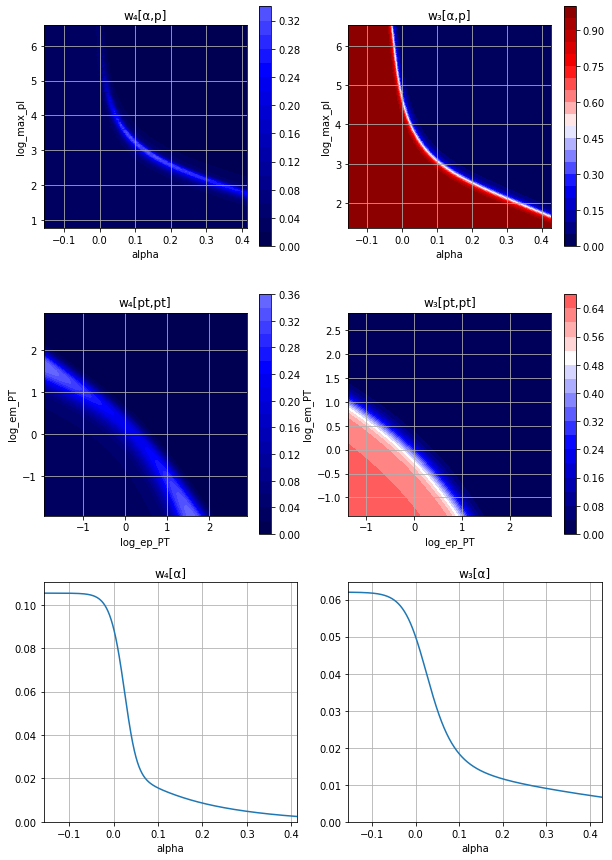

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, d in enumerate([w_la, w_la3, w_ptpt, w_ptpt3, w_a4, w_a3]):
    ds = d.dataset()
    w_np = ds.as_numpy(d.model)
    feat = len(ds.features)
    if feat == 2:
        plot_field(w_np, ds, d.name, ax=ax[i//2,i%2])
    elif feat == 1:
        plot_one(w_np, ds, d.name, ax=ax[i//2,i%2], vmax=None)
plt.show()

In [66]:
df_w = pd.DataFrame(index=df_index)
for w in [w_la, w_la3, w_ptpt, w_ptpt3, w_a4, w_a3]:
    ds = w.dataset()
    name = w.name
    name1 = "1-%s" % name
    r_name = "R[%s]" % name
    df_w[name1] = None
    for idx in range(4):
        x_, y_, m_ = make_dataset(ds.features, [idx])
        wd = w.w_model_np()(x_)
        df_w.loc[df_w.index[idx],name1] = 1-np.mean(wd)
    df_w[r_name] = df_w.loc[df.index[1],name1] / df_w[name1]
df_w

1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.902344   1.086052  0.802429   1.221303    0.941619   
B⁺→K⁺J/ψ(→ee)    0.979993        1.0  0.980009        1.0    0.979987   
B⁺→K⁺ψ(2S)(→ee)  0.989132    0.99076  0.985519   0.994409    0.988433   
D⁺→π⁺φ(→ee)      0.929987    1.05377  0.308223    3.17954    0.929973   

                R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.040747    0.903124      1.08511  0.972627  1.007586   
B⁺→K⁺J/ψ(→ee)            1.0     0.97999          1.0  0.980006       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.991456    0.986154     0.993749  0.981553  0.998424   
D⁺→π⁺φ(→ee)         1.053781    0.576591     1.699626  0.973884  1.006286   

                  1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.975746  1.004356  
B⁺→K⁺J/ψ(→ee)    0.979996       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.980982  0.998995  
D⁺→π⁺φ(→ee)       0.97636  1.003724

### Conditional plots

In [67]:
def plot_e(w_obj, feature, bins, comment=None, ax=None):
    axis = plt.gca() if ax is None else ax
    ds = w_obj.dataset()
    ds_features = ds.features
    name = w_obj.name
    ds_comment = name if comment is None else "%s, %s" % (name, comment)
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = ds.as_numpy(w_obj.model)
    for label, idx in mf.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label]
        #print(wd.shape, q2d.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=df_index[idx])
    axis.set_title("e(%s) for %s" % (feature, name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

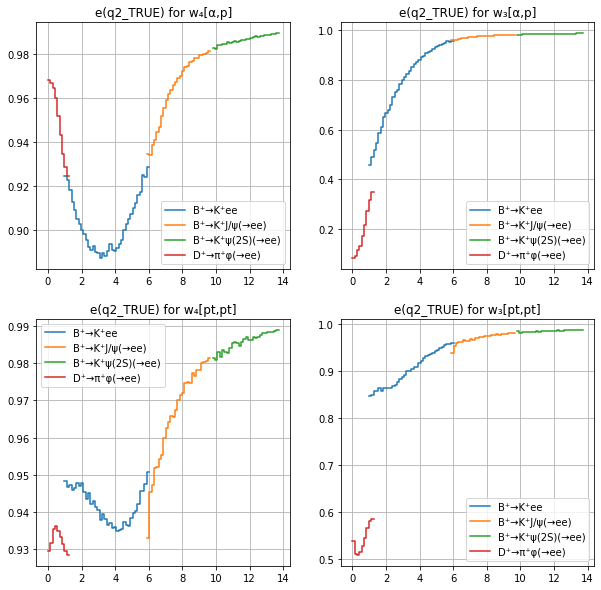

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_la, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[0,0])
plot_e(w_la3, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[0,1])
plot_e(w_ptpt, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[1,0])
plot_e(w_ptpt3, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[1,1])
plt.show()

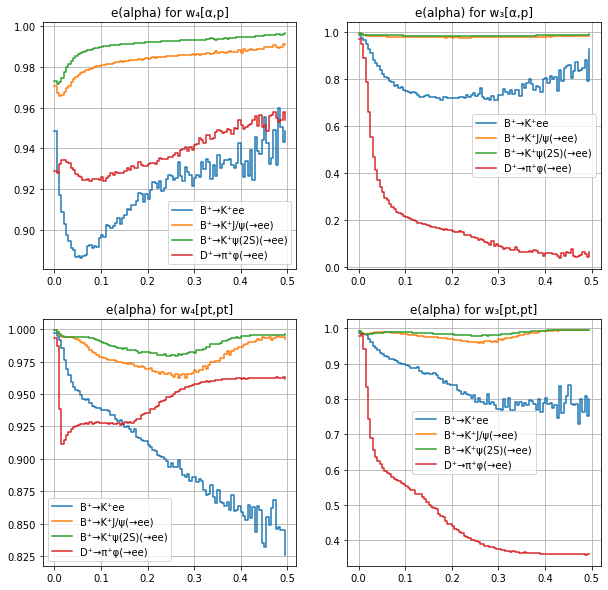

In [69]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_la, "alpha", bins=np.linspace(0,0.5,101), ax=ax[0,0])
plot_e(w_la3, "alpha", bins=np.linspace(0,0.5,101), ax=ax[0,1])
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.5,101), ax=ax[1,0])
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.5,101), ax=ax[1,1])
plt.show()

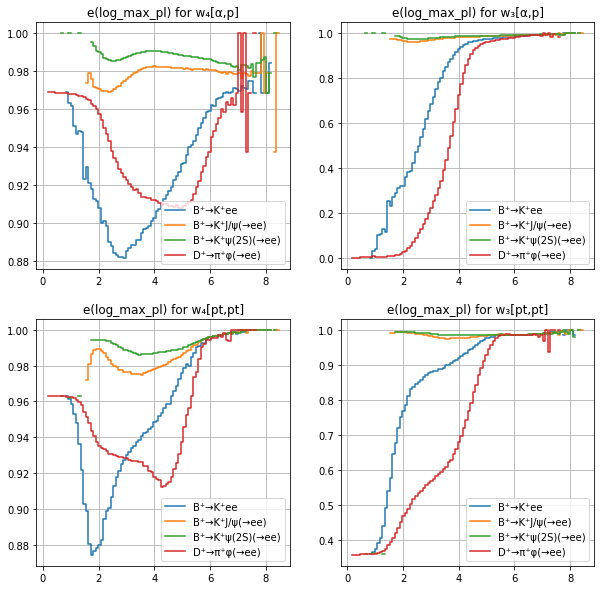

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_la, "log_max_pl", bins=np.linspace(0,9,101), ax=ax[0,0])
plot_e(w_la3, "log_max_pl", bins=np.linspace(0,9,101), ax=ax[0,1])
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(0,9,101), ax=ax[1,0])
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(0,9,101), ax=ax[1,1])
plt.show()

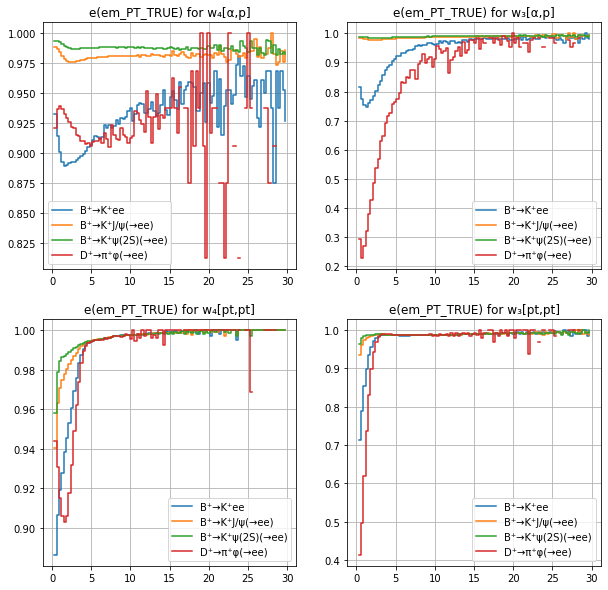

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_la, "em_PT_TRUE", bins=np.linspace(0,30,101), ax=ax[0,0])
plot_e(w_la3, "em_PT_TRUE", bins=np.linspace(0,30,101), ax=ax[0,1])
plot_e(w_ptpt, "em_PT_TRUE", bins=np.linspace(0,30,101), ax=ax[1,0])
plot_e(w_ptpt3, "em_PT_TRUE", bins=np.linspace(0,30,101), ax=ax[1,1])
plt.show()

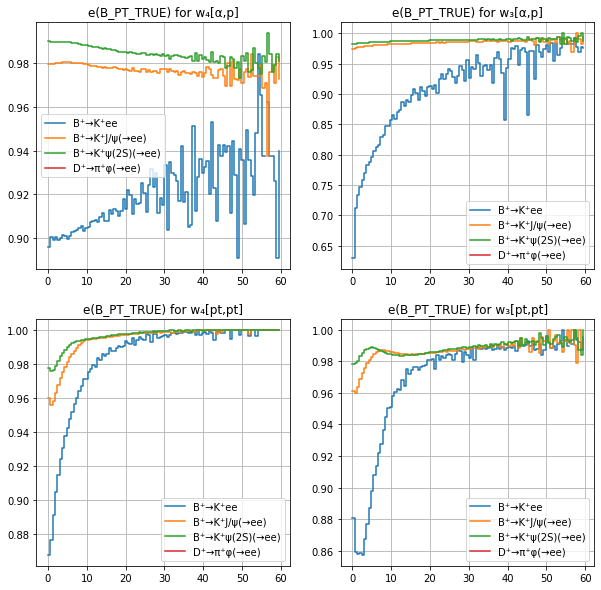

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_la, "B_PT_TRUE", bins=np.linspace(0,60,101), ax=ax[0,0])
plot_e(w_la3, "B_PT_TRUE", bins=np.linspace(0,60,101), ax=ax[0,1])
plot_e(w_ptpt, "B_PT_TRUE", bins=np.linspace(0,60,101), ax=ax[1,0])
plot_e(w_ptpt3, "B_PT_TRUE", bins=np.linspace(0,60,101), ax=ax[1,1])
plt.show()

### Single feature

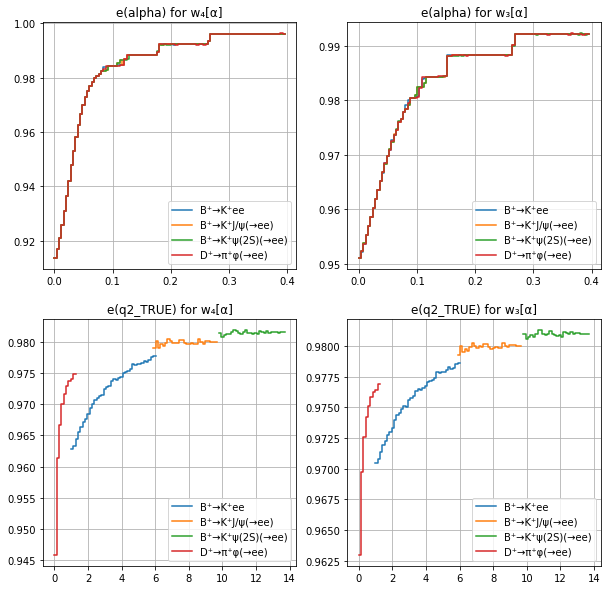

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_e(w_a4, "alpha", bins=np.linspace(0,0.4,101), ax=ax[0,0])
plot_e(w_a3, "alpha", bins=np.linspace(0,0.4,101), ax=ax[0,1])
plot_e(w_a4, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[1,0])
plot_e(w_a3, "q2_TRUE", bins=np.linspace(0,14,101), ax=ax[1,1])
plt.show()

###

In [74]:
def show_est(est, name):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(4):
        ds = est.ds
        w_np = ds.as_numpy(lambda x : torch.softmax(est.model(x), dim=-1)[:,i])
        plot_field(w_np, ds, "%s[%d]"%(name, i), ax=ax[i//2,i%2])
    plt.show()

In [75]:
def show_fns(w):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(4):
        ds = w.dataset()
        w_np = ds.as_numpy(lambda x : w.model[0](x)[:,i])
        plot_field(w_np, ds, "%s[%d]"%(w.name, i), ax=ax[i//2,i%2])
    plt.show()

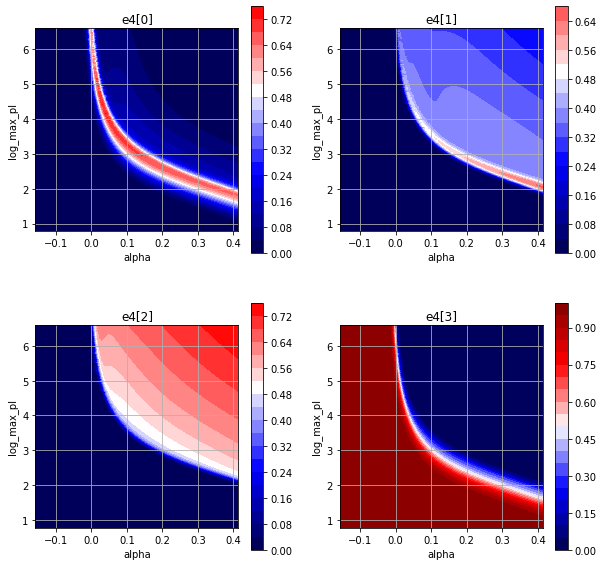

In [76]:
show_est(e_la, "e4")

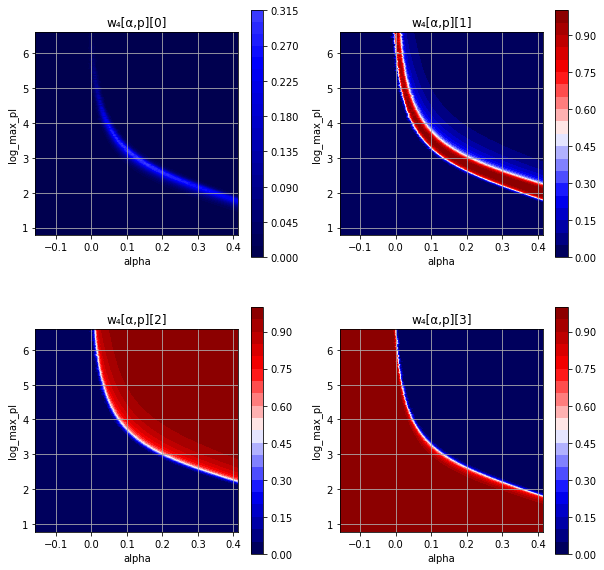

In [77]:
show_fns(w_la)

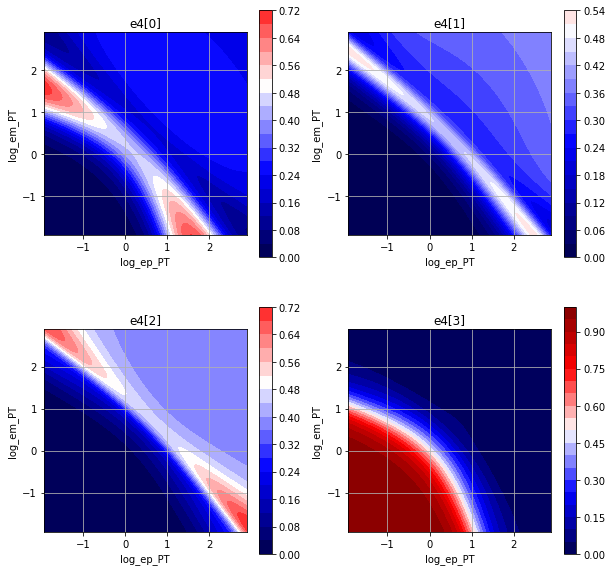

In [78]:
show_est(e_ptpt, "e4")

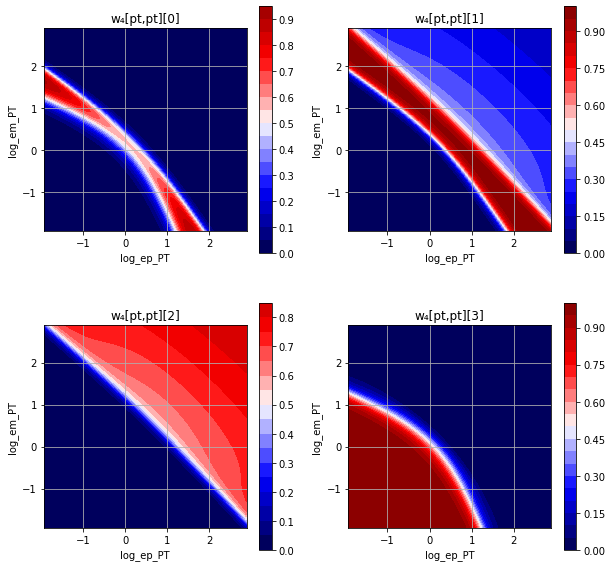

In [79]:
show_fns(w_ptpt)